# Fake News Classifier Project

## By Phelipe Martins

In [104]:
from keras.models import Sequential
from keras.layers import LSTM
from keras import layers
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import csv
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
#Evaluate model performance.
from sklearn import metrics
from html import unescape
import matplotlib.pyplot as plt
import numpy as np
import itertools
from numpy import argmax
from keras.utils import to_categorical

## Function to create confusion matrix

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

In [3]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [149]:
def plot_line_chart(x, y, xlabel, ylabel, title):
    x = x
    y = y
    plt.plot(x, y, color='g')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

## Reading .csv files (1.000 datas - low, 10.000 datas - medium, 100.000 datas - large)

In [4]:
df_news_cleaned_low = pd.read_csv("C:\\Users\\pheli\\Documents\\fake_news_dataset\\news_cleaned_low.csv")

df_news_cleaned_medium = pd.read_csv("C:\\Users\\pheli\\Documents\\fake_news_dataset\\news_cleaned_medium.csv")

df_news_cleaned_large = pd.read_csv("C:\\Users\\pheli\\Documents\\fake_news_dataset\\news_cleaned_large.csv")

df_news_cleaned_low = df_news_cleaned_low.drop('Unnamed: 0', axis=1)
df_news_cleaned_low = df_news_cleaned_low.drop('Unnamed: 0.1', axis=1)
df_news_cleaned_low = df_news_cleaned_low.sort_values(by=['id'])

df_news_cleaned_medium = df_news_cleaned_medium.drop('Unnamed: 0', axis=1)
df_news_cleaned_medium = df_news_cleaned_medium.drop('Unnamed: 0.1', axis=1)
df_news_cleaned_medium = df_news_cleaned_medium.sort_values(by=['id'])

df_news_cleaned_large = df_news_cleaned_large.drop('Unnamed: 0', axis=1)
df_news_cleaned_large = df_news_cleaned_large.drop('Unnamed: 0.1', axis=1)
df_news_cleaned_large = df_news_cleaned_large.sort_values(by=['id'])

In [32]:
df_news_cleaned_low.head()

,id,domain,type,content,title
809,11737,beforeitsnews.com,FAKE,Trump: “Defining Deviancy Down” With Lots of T...,Trump: “Defining Deviancy Down” With Lots of T...
378,12512,beforeitsnews.com,FAKE,Ron Paul predicts a Libertarian will run compe...,Ron Paul predicts a Libertarian will run compe...
973,15206,beforeitsnews.com,FAKE,See a Flirtatious Lunar Eclipse This Friday Ni...,See a Flirtatious Lunar Eclipse This Friday Night
722,16849,beforeitsnews.com,FAKE,How Snowden proved Congress needs to Read the ...,How Snowden proved Congress needs to Read the ...
499,19053,beforeitsnews.com,FAKE,U.S. Gives Soros Groups Millions to Destabiliz...,U.S. Gives Soros Groups Millions to Destabiliz...


In [30]:
df_news_cleaned_medium.head()

,id,domain,type,content,title
6583,1074,christianpost.com,REAL,(Photo: REUTERS/Jason Lee) A cross is seen beh...,"Chinese Gov't Fines Pastors Over $1M, Demandin..."
6039,1249,beforeitsnews.com,FAKE,"Healthy to Eat, Unhealthy to Grow: Strawberrie...","Healthy to Eat, Unhealthy to Grow: Strawberrie..."
4001,3052,christianpost.com,REAL,(Photo: Reuters/Jayanta Shaw) School children ...,Thousands of Indian Christians Protest After P...
7137,5201,beforeitsnews.com,FAKE,Headline: Bitcoin & Blockchain Searches Exceed...,Jordan Peterson: Everything you do matters. Tr...
9245,6548,beforeitsnews.com,FAKE,Looming Catastrophe Hanging Over Our Heads – G...,Looming Catastrophe Hanging Over Our Heads – G...


In [31]:
df_news_cleaned_large.head()

,id,domain,type,content,title
94889,449,beforeitsnews.com,FAKE,Have You Seen Palladium’s Tradable Price Patte...,Have You Seen Palladium’s Tradable Price Pattern?
69808,471,christianpost.com,REAL,REUTERS/Pawel Kopczynski An illustration pictu...,NSA Has Been Running a Voice-Recognition Syste...
17544,518,christianpost.com,REAL,(Screengrab: YouTube / ABC15 Arizona) Evangeli...,Franklin Graham Responds to Trump-Porn Star Al...
30926,643,christianpost.com,REAL,(Photo: Reuters/Jasen Vinlove/USA TODAY Sports...,Tim Tebow Continues to Defy Odds: N.Y. Mets In...
37790,726,beforeitsnews.com,FAKE,Sienna Resources kicks off ground survey at ex...,Sienna Resources kicks off ground survey at ex...


In [33]:
df_news_cleaned_low.shape

(1000, 5)

In [35]:
df_news_cleaned_medium.shape

(10000, 5)

In [36]:
df_news_cleaned_large.shape

(100000, 5)

In [29]:
df_news_cleaned_low.isnull().sum()

id         0
domain     0
type       0
content    0
title      0
dtype: int64

## Some preprocessing functions

In [5]:
spacy.load('en')
lemmatizer = spacy.lang.en.English()
stopwords = list(spacy.lang.en.stop_words.STOP_WORDS)


# remove html entities from docs and
# set everything to lowercase
def preprocessor(doc):
    return(unescape(doc).lower())
# tokenize the doc and lemmatize its tokens
def tokenizer(doc):
    tokens = lemmatizer(doc)
    #When I use this code the accuracy decreases
    tokens = [token for token in tokens if token.is_ascii and token.is_alpha]
    return([token.lemma_  if token.lemma_ != '-PRON-' else token.lower_ for token in tokens])

In [6]:
y = df_news_cleaned_low.type

#getting the training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_news_cleaned_low.content, y, test_size =0.33, random_state=53)

### Using Tfidf

In [187]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=0.02, max_df=0.6, tokenizer=tokenizer, preprocessor=preprocessor)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [188]:
print(tfidf_vectorizer.get_feature_names())

['2', '3', '4', '5', 'abandon', 'ability', 'able', 'abuse', 'academy', 'accept', 'access', 'accompany', 'accord', 'account', 'accuse', 'achieve', 'acknowledge', 'act', 'action', 'active', 'activity', 'actually', 'add', 'addition', 'additional', 'address', 'adjust', 'administration', 'admit', 'adult', 'advance', 'advantage', 'advertise', 'advertisement', 'advocate', 'affair', 'affect', 'africa', 'african', 'afternoon', 'age', 'agency', 'agent', 'ago', 'agree', 'agreement', 'ahead', 'aid', 'aim', 'air', 'al', 'alert', 'allow', 'ally', 'alternative', 'america', 'american', 'americans', 'amid', 'analysis', 'analyst', 'andrew', 'angeles', 'animal', 'anniversary', 'announce', 'announcement', 'annual', 'answer', 'anti', 'ap', 'apartment', 'apparently', 'appeal', 'appear', 'appearance', 'application', 'apply', 'approach', 'approve', 'april', 'area', 'argue', 'argument', 'arm', 'army', 'arrest', 'arrive', 'art', 'article', 'artist', 'asia', 'aside', 'ask', 'aspect', 'asset', 'assistant', 'assoc

### Using Naive Bayes classifier - Tfidf

------------ Testing alphas with fit_prior=True---------------
Alpha: 0.01 Score: 0.85455
Alpha: 0.02 Score: 0.85455
Alpha: 0.03 Score: 0.85758
Alpha: 0.04 Score: 0.85758
Alpha: 0.05 Score: 0.85758
Alpha: 0.06 Score: 0.85758
Alpha: 0.07 Score: 0.85758
Alpha: 0.08 Score: 0.85758
Alpha: 0.09 Score: 0.85758
Alpha: 0.10 Score: 0.86364
Alpha: 0.11 Score: 0.86364
Alpha: 0.12 Score: 0.85758
Alpha: 0.13 Score: 0.85758
Alpha: 0.14 Score: 0.85758
Alpha: 0.15 Score: 0.85758
Alpha: 0.16 Score: 0.86061
Alpha: 0.17 Score: 0.86061
Alpha: 0.18 Score: 0.86061
Alpha: 0.19 Score: 0.86061
Alpha: 0.20 Score: 0.86061
Alpha: 0.21 Score: 0.86061
Alpha: 0.22 Score: 0.86061
Alpha: 0.23 Score: 0.85758
Alpha: 0.24 Score: 0.85758
Alpha: 0.25 Score: 0.85758
Alpha: 0.26 Score: 0.85758
Alpha: 0.27 Score: 0.85758
Alpha: 0.28 Score: 0.85758
Alpha: 0.29 Score: 0.85758
Alpha: 0.30 Score: 0.85758
Alpha: 0.31 Score: 0.85455
Alpha: 0.32 Score: 0.85455
Alpha: 0.33 Score: 0.85455
Alpha: 0.34 Score: 0.85455
Alpha: 0.35 Score: 

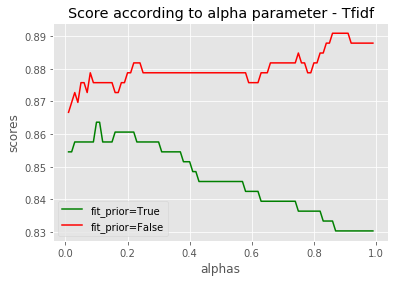

In [272]:
# TESTING PARAMETERS 1

best_alpha = -1
last_score = -1
alphas = []
scores = []
fit_prior = True
print('------------ Testing alphas with fit_prior=True---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier = MultinomialNB(alpha=alpha, fit_prior=True)
    nb_classifier.fit(tfidf_train, y_train)
    nb_pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, nb_pred)
    scores.append(score)
    alphas.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')    


# TESTING PARAMETERS 2

alphas2 = []
scores2 = []
print('------------ Testing alphas with fit_prior=False---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier = MultinomialNB(alpha=alpha, fit_prior=False)
    nb_classifier.fit(tfidf_train, y_train)
    nb_pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, nb_pred)
    scores2.append(score)
    alphas2.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
        fit_prior = False
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')  
firstplt, = plt.plot(alphas, scores, color='g', label='fit_prior=True')
secondplt, = plt.plot(alphas2, scores2, color='red', label='fit_prior=False')
plt.legend(handles=[firstplt,secondplt])
plt.xlabel('alphas')
plt.ylabel('scores')
plt.title('Score according to alpha parameter - Tfidf')
plt.show()




Best alpha:  0.02


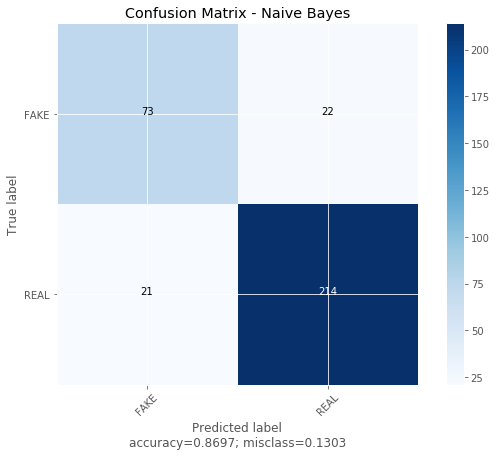

In [299]:
# USING BEST PARAMETERS 

print('\nBest alpha: ', best_alpha)


#best alpha = 0.1
nb_classifier = MultinomialNB(alpha=best_alpha, fit_prior=fit_prior)

    
#this will determine the internal parameters based on the dataset.
nb_classifier.fit(tfidf_train, y_train)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred = nb_classifier.predict(tfidf_test)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm = metrics.confusion_matrix(y_test, nb_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - Naive Bayes')

### Using SVM - Tfidf

C: 0.01 Score: 0.71212
C: 0.02 Score: 0.71212
C: 0.03 Score: 0.71212
C: 0.04 Score: 0.71212
C: 0.05 Score: 0.71212
C: 0.06 Score: 0.71212
C: 0.07 Score: 0.71212
C: 0.08 Score: 0.71212
C: 0.09 Score: 0.71515
C: 0.10 Score: 0.71818
C: 0.11 Score: 0.72121
C: 0.12 Score: 0.73030
C: 0.13 Score: 0.73939
C: 0.14 Score: 0.74545
C: 0.15 Score: 0.74545
C: 0.16 Score: 0.75758
C: 0.17 Score: 0.75758
C: 0.18 Score: 0.76061
C: 0.19 Score: 0.76970
C: 0.20 Score: 0.77273
C: 0.21 Score: 0.77879
C: 0.22 Score: 0.78182
C: 0.23 Score: 0.78788
C: 0.24 Score: 0.79697
C: 0.25 Score: 0.80909
C: 0.26 Score: 0.80909
C: 0.27 Score: 0.81515
C: 0.28 Score: 0.81818
C: 0.29 Score: 0.82121
C: 0.30 Score: 0.82424
C: 0.31 Score: 0.82727
C: 0.32 Score: 0.83030
C: 0.33 Score: 0.83636
C: 0.34 Score: 0.83333
C: 0.35 Score: 0.83939
C: 0.36 Score: 0.84242
C: 0.37 Score: 0.84545
C: 0.38 Score: 0.85152
C: 0.39 Score: 0.85455
C: 0.40 Score: 0.85758
C: 0.41 Score: 0.86061
C: 0.42 Score: 0.86667
C: 0.43 Score: 0.86970
C: 0.44 Sco

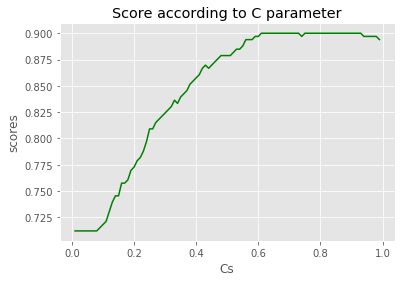

In [274]:
# TESTING PARAMETERS 1

best_C = -1
last_score = -1
Cs = []
scores = []

for C in np.arange(0.01,1,.01):
    svm_classifier = svm.SVC(kernel ='linear', C=C)
    svm_classifier.fit(tfidf_train, y_train)
    svm_pred = svm_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, svm_pred)
    scores.append(score)
    Cs.append(C)
    if score > last_score:
        last_score = score
        best_C = C
        fit_prior = False
    print("C: {:.2f} Score: {:.5f}".format(C, score))
    
plot_line_chart(Cs, scores, 'Cs', 'scores', 'Score according to C parameter - Tfidf')


Best C:  0.61


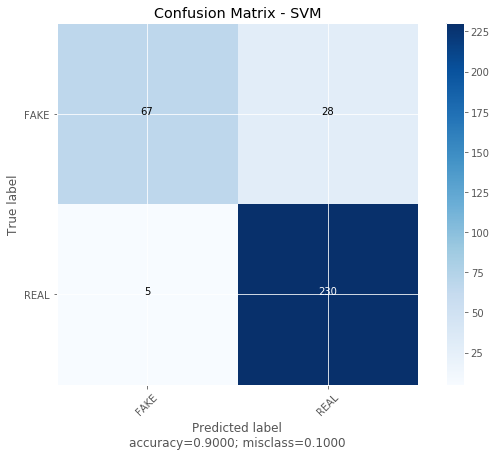

In [275]:
print('\nBest C: ', best_C)

svm_classifier = svm.SVC(kernel ='linear', C=best_C)
svm_classifier.fit(tfidf_train, y_train)
svm_pred = svm_classifier.predict(tfidf_test)
svm_cm = metrics.confusion_matrix(y_test, svm_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - SVM')


### Using CountVectorizer (Bag-of-words)

In [276]:
count_vectorizer = CountVectorizer(stop_words='english', min_df=0.02, max_df=0.6, tokenizer=tokenizer, preprocessor=preprocessor) #turns my text into bag-of-words vectors similar to a Gensim corpus
                                                         #it also remove english stop words from the plot summaries as a 
                                                         #preprocessing step
        
#Each token now acts as a feature for the machine learning classification problem, just like the flowers measurement in 
#the iris dataset

count_train = count_vectorizer.fit_transform(X_train) #Create the bag-of-words vectors
#fit_transform is a handy shortcut which will call the model's fit and then transform methods
#generates a mapping of words with IDs and vectors representing how many times each word appears in the plot
#Operates differently for each model, but generally fit will find parameters or norms in the data and transform 
#will apply the model's underlying algorithm or approximation
#For the CountVectorizer class, fit_transform will create the bag-of-words dictionary and vectors for each document using
#the training data

count_test = count_vectorizer.transform(X_test) #Create bag-of-words vector using the same dictionary

In [277]:
print(count_vectorizer.get_feature_names())

['2', '3', '4', '5', 'abandon', 'ability', 'able', 'abuse', 'academy', 'accept', 'access', 'accompany', 'accord', 'account', 'accuse', 'achieve', 'acknowledge', 'act', 'action', 'active', 'activity', 'actually', 'add', 'addition', 'additional', 'address', 'adjust', 'administration', 'admit', 'adult', 'advance', 'advantage', 'advertise', 'advertisement', 'advocate', 'affair', 'affect', 'africa', 'african', 'afternoon', 'age', 'agency', 'agent', 'ago', 'agree', 'agreement', 'ahead', 'aid', 'aim', 'air', 'al', 'alert', 'allow', 'ally', 'alternative', 'america', 'american', 'americans', 'amid', 'analysis', 'analyst', 'andrew', 'angeles', 'animal', 'anniversary', 'announce', 'announcement', 'annual', 'answer', 'anti', 'ap', 'apartment', 'apparently', 'appeal', 'appear', 'appearance', 'application', 'apply', 'approach', 'approve', 'april', 'area', 'argue', 'argument', 'arm', 'army', 'arrest', 'arrive', 'art', 'article', 'artist', 'asia', 'aside', 'ask', 'aspect', 'asset', 'assistant', 'assoc

### Using Naive Bayes classifier - CountVectorizer

------------ Testing alphas with fit_prior=True---------------
Alpha: 0.01 Score: 0.85455
Alpha: 0.02 Score: 0.85758
Alpha: 0.03 Score: 0.85758
Alpha: 0.04 Score: 0.85758
Alpha: 0.05 Score: 0.85758
Alpha: 0.06 Score: 0.85758
Alpha: 0.07 Score: 0.85758
Alpha: 0.08 Score: 0.85758
Alpha: 0.09 Score: 0.85758
Alpha: 0.10 Score: 0.85758
Alpha: 0.11 Score: 0.85758
Alpha: 0.12 Score: 0.85758
Alpha: 0.13 Score: 0.85758
Alpha: 0.14 Score: 0.85758
Alpha: 0.15 Score: 0.85758
Alpha: 0.16 Score: 0.85758
Alpha: 0.17 Score: 0.85758
Alpha: 0.18 Score: 0.85758
Alpha: 0.19 Score: 0.85758
Alpha: 0.20 Score: 0.85758
Alpha: 0.21 Score: 0.85758
Alpha: 0.22 Score: 0.85758
Alpha: 0.23 Score: 0.85758
Alpha: 0.24 Score: 0.85758
Alpha: 0.25 Score: 0.85758
Alpha: 0.26 Score: 0.85455
Alpha: 0.27 Score: 0.85455
Alpha: 0.28 Score: 0.85455
Alpha: 0.29 Score: 0.85455
Alpha: 0.30 Score: 0.85758
Alpha: 0.31 Score: 0.85758
Alpha: 0.32 Score: 0.85758
Alpha: 0.33 Score: 0.85758
Alpha: 0.34 Score: 0.85455
Alpha: 0.35 Score: 

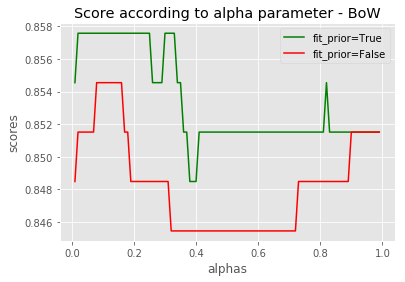

In [278]:
# TESTING PARAMETERS 1

best_alpha = -1
last_score = -1
alphas = []
scores = []
fit_prior = True
print('------------ Testing alphas with fit_prior=True---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_2 = MultinomialNB(alpha=alpha, fit_prior=True)
    nb_classifier_2.fit(count_train, y_train)
    nb_pred_2 = nb_classifier_2.predict(count_test)
    score = metrics.accuracy_score(y_test, nb_pred_2)
    scores.append(score)
    alphas.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')    


# TESTING PARAMETERS 2

alphas2 = []
scores2 = []
print('------------ Testing alphas with fit_prior=False---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_2 = MultinomialNB(alpha=alpha, fit_prior=False)
    nb_classifier_2.fit(count_train, y_train)
    nb_pred_2 = nb_classifier_2.predict(count_test)
    score = metrics.accuracy_score(y_test, nb_pred_2)
    scores2.append(score)
    alphas2.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
        fit_prior = False
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')  
firstplt, = plt.plot(alphas, scores, color='g', label='fit_prior=True')
secondplt, = plt.plot(alphas2, scores2, color='red', label='fit_prior=False')
plt.legend(handles=[firstplt,secondplt])
plt.xlabel('alphas')
plt.ylabel('scores')
plt.title('Score according to alpha parameter - BoW')
plt.show()



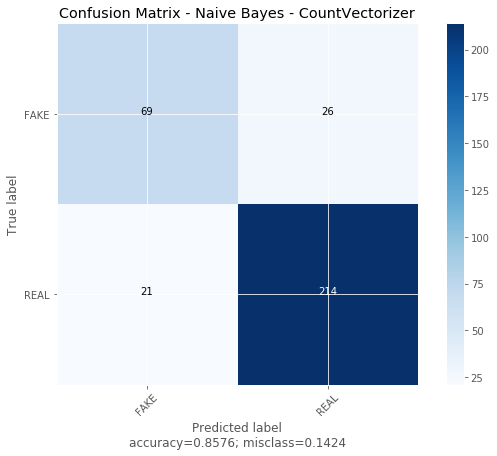

In [279]:
#best alpha = 0.1
nb_classifier_2 = MultinomialNB(alpha=best_alpha, fit_prior=fit_prior)

#this will determine the internal parameters based on the dataset.
nb_classifier_2.fit(count_train, y_train)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred_2 = nb_classifier_2.predict(count_test)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm_2 = metrics.confusion_matrix(y_test, nb_pred_2, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm_2, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - Naive Bayes - CountVectorizer')

### Using SVM - CountVectorizer

C: 0.01 Score: 0.85758
C: 0.02 Score: 0.86970
C: 0.03 Score: 0.88182
C: 0.04 Score: 0.89091
C: 0.05 Score: 0.88485
C: 0.06 Score: 0.89091
C: 0.07 Score: 0.88485
C: 0.08 Score: 0.88182
C: 0.09 Score: 0.88182
C: 0.10 Score: 0.87273
C: 0.11 Score: 0.87273
C: 0.12 Score: 0.87273
C: 0.13 Score: 0.87576
C: 0.14 Score: 0.86970
C: 0.15 Score: 0.86667
C: 0.16 Score: 0.86667
C: 0.17 Score: 0.87273
C: 0.18 Score: 0.87273
C: 0.19 Score: 0.87273
C: 0.20 Score: 0.87273
C: 0.21 Score: 0.86970
C: 0.22 Score: 0.86667
C: 0.23 Score: 0.86970
C: 0.24 Score: 0.86970
C: 0.25 Score: 0.87273
C: 0.26 Score: 0.86970
C: 0.27 Score: 0.87273
C: 0.28 Score: 0.86970
C: 0.29 Score: 0.86970
C: 0.30 Score: 0.86364
C: 0.31 Score: 0.86364
C: 0.32 Score: 0.86667
C: 0.33 Score: 0.86667
C: 0.34 Score: 0.86970
C: 0.35 Score: 0.86970
C: 0.36 Score: 0.86970
C: 0.37 Score: 0.86970
C: 0.38 Score: 0.87273
C: 0.39 Score: 0.87273
C: 0.40 Score: 0.86970
C: 0.41 Score: 0.86970
C: 0.42 Score: 0.86970
C: 0.43 Score: 0.86970
C: 0.44 Sco

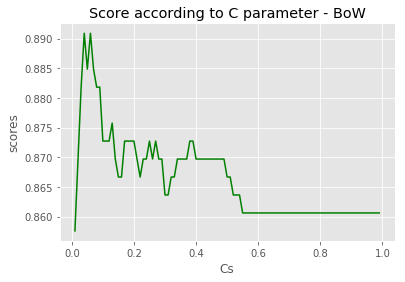

In [280]:
# TESTING PARAMETERS 1

best_C = -1
last_score = -1
Cs = []
scores = []

for C in np.arange(0.01,1,.01):
    svm_classifier_2 = svm.SVC(kernel ='linear', C=C)
    svm_classifier_2.fit(count_train, y_train)
    svm_pred_2 = svm_classifier_2.predict(count_test)
    score = metrics.accuracy_score(y_test, svm_pred_2)
    scores.append(score)
    Cs.append(C)
    if score > last_score:
        last_score = score
        best_C = C
        fit_prior = False
    print("C: {:.2f} Score: {:.5f}".format(C, score))
    
plot_line_chart(Cs, scores, 'Cs', 'scores', 'Score according to C parameter - BoW')

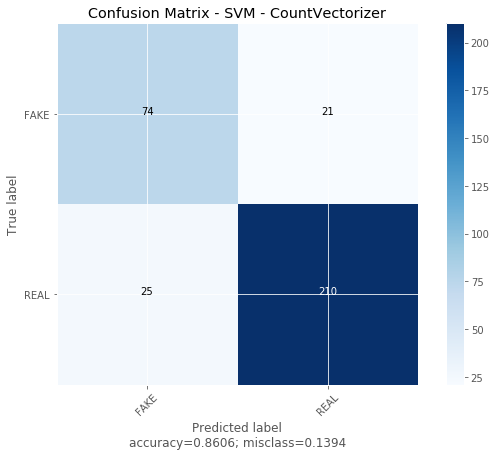

In [281]:
#best C=0.9
svm_classifier_2 = svm.SVC(kernel ='linear', C=0.9)
svm_classifier_2.fit(count_train, y_train)
svm_pred_2 = svm_classifier_2.predict(count_test)
svm_cm_2 = metrics.confusion_matrix(y_test, svm_pred_2, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm_2, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - SVM - CountVectorizer')

### Keras

In [7]:
# integer encode
#transform y values ['FAKE', 'REAL'] into 0s and 1s
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train.values)
integer_encoded_test = label_encoder.fit_transform(y_test.values)
print(integer_encoded_train)

[1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0
 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1
 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1
 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0
 1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1
 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1
 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 1
 0 1 1 1 0 1 0 1 1 0 0 1 

### Word Embeddings

In [38]:
X_2_train[500].shape

(10000,)

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#return a list of sequences (one per text input)
X_2_train = tokenizer.texts_to_sequences(X_train)

X_2_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1 #adding 1 because of reserved 0 index

maxlen = 0
for sequence in X_2_train:
    maxlen = maxlen + len(sequence)

for sequence in X_2_test:
    maxlen = maxlen + len(sequence)

#maxlen will be the arithmetic mean of the sum of sequences    
maxlen = round(maxlen/(len(X_2_train)+len(X_2_test)))
    



#avoid the problem that each text sequence has different length of words
X_2_train = pad_sequences(X_2_train, padding='post', maxlen=maxlen) #pads the sequence of words with zeros
X_2_test = pad_sequences(X_2_test, padding='post', maxlen=maxlen) #pads the sequence of words with zeros

print(vocab_size)


28632


### Using Convolutional Neural Network

In [157]:
embedding_dim = round((vocab_size/maxlen))

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, padding='same', activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 495, 58)           1660656   
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 495, 128)          37248     
_________________________________________________________________
global_max_pooling1d_43 (Glo (None, 128)               0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 11        
Total params: 1,699,205
Trainable params: 1,699,205
Non-trainable params: 0
_________________________________________________________________


Train on 670 samples, validate on 330 samples
Epoch 1/2
670/670 [==============================] - ETA: 50s - loss: 0.7299 - acc: 0.40 - ETA: 30s - loss: 0.7295 - acc: 0.39 - ETA: 22s - loss: 0.7224 - acc: 0.42 - ETA: 18s - loss: 0.7254 - acc: 0.37 - ETA: 16s - loss: 0.7263 - acc: 0.35 - ETA: 14s - loss: 0.7214 - acc: 0.35 - ETA: 12s - loss: 0.7180 - acc: 0.37 - ETA: 11s - loss: 0.7140 - acc: 0.39 - ETA: 10s - loss: 0.7109 - acc: 0.42 - ETA: 9s - loss: 0.7090 - acc: 0.4281 - ETA: 8s - loss: 0.7054 - acc: 0.448 - ETA: 7s - loss: 0.7015 - acc: 0.468 - ETA: 6s - loss: 0.6980 - acc: 0.488 - ETA: 5s - loss: 0.6937 - acc: 0.504 - ETA: 4s - loss: 0.6924 - acc: 0.510 - ETA: 3s - loss: 0.6882 - acc: 0.525 - ETA: 3s - loss: 0.6860 - acc: 0.534 - ETA: 2s - loss: 0.6822 - acc: 0.548 - ETA: 1s - loss: 0.6818 - acc: 0.551 - ETA: 0s - loss: 0.6793 - acc: 0.559 - 16s 24ms/step - loss: 0.6808 - acc: 0.5552 - val_loss: 0.6138 - val_acc: 0.7121
Epoch 2/2
330/330 [==============================] - ETA:  -

330/330 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 1ms/step
Train on 670 samples, validate on 330 samples
Epoch 1/5
670/670 [==============================] - ETA: 13s - loss: 0.0330 - acc: 1.00 - ETA: 12s - loss: 0.0302 - acc: 1.00 - ETA: 12s - loss: 0.0255 - acc: 1.00 - ETA: 11s - loss: 0.0252 - acc: 1.00 - ETA: 10s - loss: 0.0247 - acc: 1.00 - ETA: 9s - loss: 0.0261 - acc: 1.0000 - ETA: 9s - loss: 0.0247 - acc: 1.000 - ETA: 8s - loss: 0.0266 - acc: 1.000 - ETA: 7s - loss: 0.0258 - acc: 1.000 - ETA: 7s - loss: 0.0249 - acc: 1.000 - ETA: 6s - loss: 0.0238 - acc: 1.000 - ETA: 5s - loss: 0.0234 - acc: 1.000 - ETA: 5s - loss: 0.0232 - acc: 1.000 - ETA: 4s - loss: 0.0225 - acc: 1.000 - ETA: 3s - loss: 0.0217 - acc: 1.000 - ETA: 3s - loss: 0.0209 - acc: 1.000 - ETA: 2s - loss: 0.0205 - acc: 1.000 - ETA: 1s - loss: 0.0204 - acc: 1.000 - ETA: 1s - loss: 0.0202 - acc: 1.000 - ETA: 0s - loss: 0.0203 - acc: 1.000 - 14s 21ms/step - loss: 0.0206 - acc: 1

670/670 [==============================] - ETA: 14s - loss: 0.0048 - acc: 1.00 - ETA: 12s - loss: 0.0048 - acc: 1.00 - ETA: 11s - loss: 0.0041 - acc: 1.00 - ETA: 11s - loss: 0.0043 - acc: 1.00 - ETA: 10s - loss: 0.0041 - acc: 1.00 - ETA: 9s - loss: 0.0037 - acc: 1.0000 - ETA: 9s - loss: 0.0038 - acc: 1.000 - ETA: 8s - loss: 0.0036 - acc: 1.000 - ETA: 7s - loss: 0.0033 - acc: 1.000 - ETA: 7s - loss: 0.0031 - acc: 1.000 - ETA: 6s - loss: 0.0032 - acc: 1.000 - ETA: 5s - loss: 0.0031 - acc: 1.000 - ETA: 5s - loss: 0.0036 - acc: 1.000 - ETA: 4s - loss: 0.0035 - acc: 1.000 - ETA: 3s - loss: 0.0034 - acc: 1.000 - ETA: 3s - loss: 0.0036 - acc: 1.000 - ETA: 2s - loss: 0.0036 - acc: 1.000 - ETA: 1s - loss: 0.0035 - acc: 1.000 - ETA: 1s - loss: 0.0036 - acc: 1.000 - ETA: 0s - loss: 0.0036 - acc: 1.000 - 14s 21ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.1894 - val_acc: 0.9242
Epoch 4/6
670/670 [==============================] - ETA: 15s - loss: 0.0027 - acc: 1.00 - ETA: 14s - loss: 0.0044 -

Epoch 6/7
670/670 [==============================] - ETA: 14s - loss: 7.5099e-04 - acc: 1.00 - ETA: 14s - loss: 8.3341e-04 - acc: 1.00 - ETA: 14s - loss: 9.7075e-04 - acc: 1.00 - ETA: 12s - loss: 8.3546e-04 - acc: 1.00 - ETA: 11s - loss: 0.0012 - acc: 1.0000   - ETA: 10s - loss: 0.0011 - acc: 1.00 - ETA: 10s - loss: 0.0011 - acc: 1.00 - ETA: 9s - loss: 0.0010 - acc: 1.0000 - ETA: 8s - loss: 0.0010 - acc: 1.000 - ETA: 8s - loss: 0.0010 - acc: 1.000 - ETA: 7s - loss: 9.9995e-04 - acc: 1.000 - ETA: 6s - loss: 0.0015 - acc: 1.0000    - ETA: 5s - loss: 0.0014 - acc: 1.000 - ETA: 5s - loss: 0.0014 - acc: 1.000 - ETA: 4s - loss: 0.0013 - acc: 1.000 - ETA: 3s - loss: 0.0013 - acc: 1.000 - ETA: 2s - loss: 0.0012 - acc: 1.000 - ETA: 2s - loss: 0.0018 - acc: 1.000 - ETA: 1s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0017 - acc: 1.000 - 16s 24ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.1978 - val_acc: 0.9273
Epoch 7/7
330/330 [==============================] - ETA:  - ETA:  - ETA:  - E

670/670 [==============================] - ETA: 16s - loss: 6.2381e-04 - acc: 1.00 - ETA: 15s - loss: 4.9608e-04 - acc: 1.00 - ETA: 14s - loss: 6.0524e-04 - acc: 1.00 - ETA: 13s - loss: 0.0016 - acc: 1.0000   - ETA: 12s - loss: 0.0014 - acc: 1.00 - ETA: 11s - loss: 0.0013 - acc: 1.00 - ETA: 10s - loss: 0.0014 - acc: 1.00 - ETA: 9s - loss: 0.0013 - acc: 1.0000 - ETA: 9s - loss: 0.0012 - acc: 1.000 - ETA: 8s - loss: 0.0011 - acc: 1.000 - ETA: 7s - loss: 0.0010 - acc: 1.000 - ETA: 6s - loss: 9.7079e-04 - acc: 1.000 - ETA: 5s - loss: 9.2825e-04 - acc: 1.000 - ETA: 5s - loss: 8.8762e-04 - acc: 1.000 - ETA: 4s - loss: 8.5821e-04 - acc: 1.000 - ETA: 3s - loss: 8.2794e-04 - acc: 1.000 - ETA: 2s - loss: 8.1280e-04 - acc: 1.000 - ETA: 2s - loss: 7.8369e-04 - acc: 1.000 - ETA: 1s - loss: 7.6463e-04 - acc: 1.000 - ETA: 0s - loss: 7.5591e-04 - acc: 1.000 - 16s 25ms/step - loss: 7.4716e-04 - acc: 1.0000 - val_loss: 0.2125 - val_acc: 0.9242
Epoch 8/8
288/670 [===========>..................] - ETA: 15

KeyboardInterrupt: 

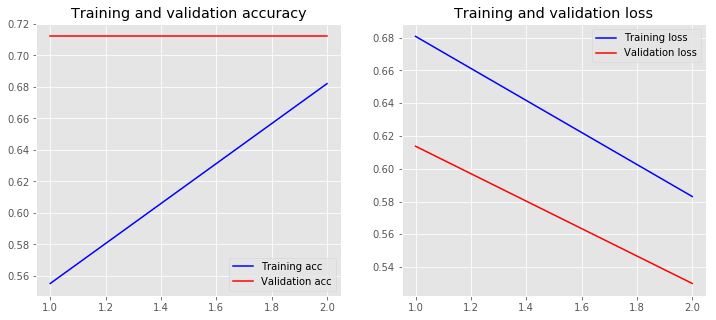

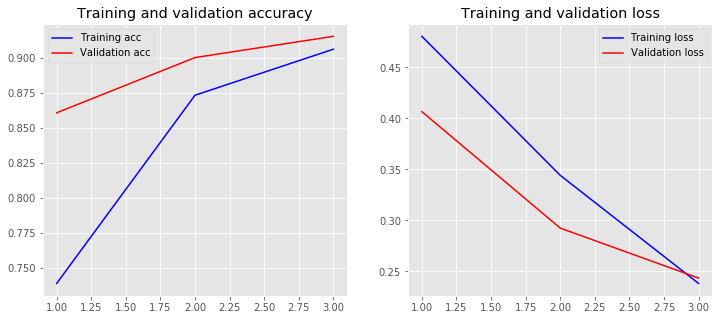

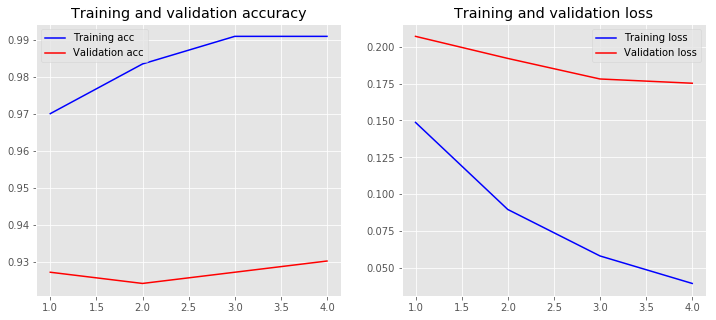

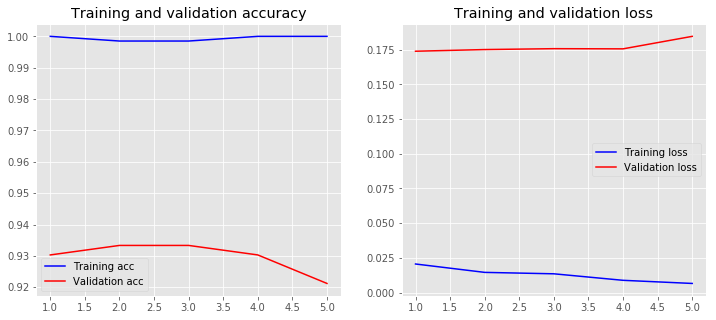

In [ ]:
best_epochs = -1
last_score = -1
epochs_vec = []
scores = []

for epochs in np.arange(2,11,1):
    history = model.fit(X_2_train, integer_encoded_train,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_2_test, integer_encoded_test),
                    batch_size=32) #batch_size >= 150 pc stops working
    plot_history(history)

    keras_pred = model.predict_classes(X_2_test, batch_size=32, verbose=1)
    score = metrics.accuracy_score(integer_encoded_test, keras_pred)
    scores.append(score)
    epochs_vec.append(epochs)
    if score > last_score and score != 1:
        last_score = score
        best_epochs = epochs

print('\n\n')
for x in np.arange(2,11,1):
    print("epochs: {:.0f} Score: {:.5f}".format(epochs_vec[x-1], scores[x-1]))
    
plot_line_chart(epochs_vec, scores, 'epochs', 'scores', 'Score according to epochs parameter - CNN')


Training Accuracy: 1.0000
Testing Accuracy:  0.9091


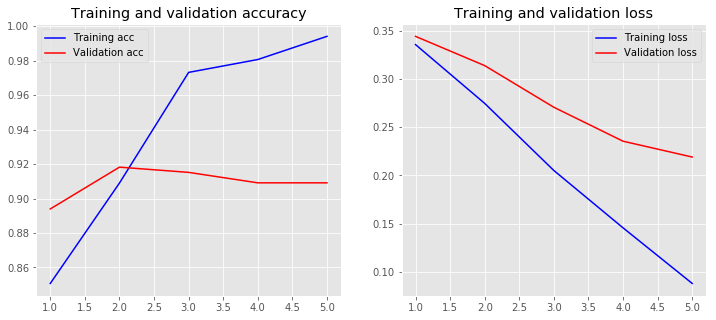

In [128]:
loss, accuracy = model.evaluate(X_2_train, integer_encoded_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_2_test, integer_encoded_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

330/330 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 1ms/step


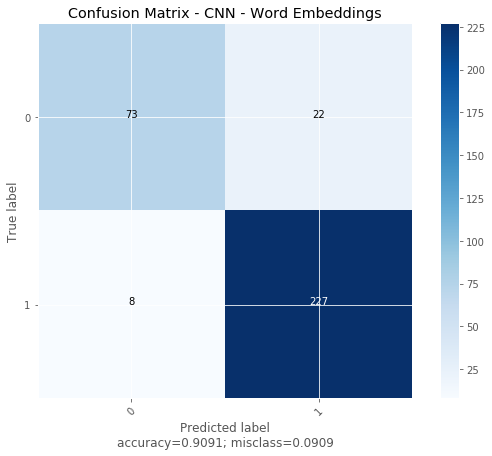

In [129]:
keras_pred = model.predict_classes(X_2_test, batch_size=32, verbose=1)
keras_cm = metrics.confusion_matrix(integer_encoded_test, keras_pred, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm, normalize=False, target_names=[0, 1], title = 'Confusion Matrix - CNN - Word Embeddings')

### Using Recurrent Neural Network

In [53]:
embedding_dim2 = 100

model2 = Sequential()
model2.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim2, input_length=maxlen))
model2.add(layers.LSTM(128))
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 8161, 100)         2863200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 2,981,749
Trainable params: 2,981,749
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
history = model2.fit(X_2_train, integer_encoded_train,
                    epochs=3,
                    verbose=1,
                    validation_data=(X_2_test, integer_encoded_test),
                    batch_size=10) #batch_size >= 150 pc stops working


Train on 670 samples, validate on 330 samples
Epoch 1/3
670/670 [==============================] - ETA: 9:39 - loss: 0.7002 - acc: 0.100 - ETA: 8:21 - loss: 0.6992 - acc: 0.250 - ETA: 8:00 - loss: 0.6898 - acc: 0.466 - ETA: 7:47 - loss: 0.6887 - acc: 0.500 - ETA: 7:29 - loss: 0.6808 - acc: 0.580 - ETA: 7:15 - loss: 0.6884 - acc: 0.533 - ETA: 7:03 - loss: 0.6803 - acc: 0.585 - ETA: 6:55 - loss: 0.6728 - acc: 0.625 - ETA: 6:49 - loss: 0.6732 - acc: 0.622 - ETA: 6:42 - loss: 0.6733 - acc: 0.620 - ETA: 6:36 - loss: 0.6667 - acc: 0.636 - ETA: 6:32 - loss: 0.6634 - acc: 0.641 - ETA: 6:30 - loss: 0.6598 - acc: 0.646 - ETA: 6:27 - loss: 0.6802 - acc: 0.621 - ETA: 6:22 - loss: 0.6904 - acc: 0.606 - ETA: 6:17 - loss: 0.6820 - acc: 0.618 - ETA: 6:11 - loss: 0.6816 - acc: 0.617 - ETA: 6:07 - loss: 0.6840 - acc: 0.611 - ETA: 6:00 - loss: 0.6810 - acc: 0.615 - ETA: 5:54 - loss: 0.6743 - acc: 0.630 - ETA: 5:49 - loss: 0.6782 - acc: 0.619 - ETA: 5:43 - loss: 0.6779 - acc: 0.618 - ETA: 5:36 - loss: 0.6

330/330 [==============================] - ETA: 31 - ETA: 25 - ETA: 19 - ETA: 14 - ETA: 8 - ETA:  - 35s 106ms/step


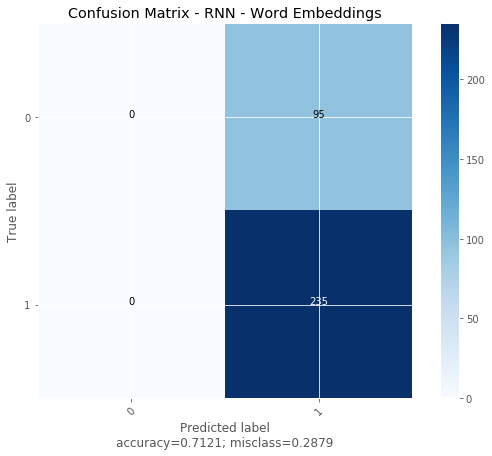

In [55]:
keras_pred2 = model2.predict_classes(X_2_test, batch_size=50, verbose=1)
keras_cm2 = metrics.confusion_matrix(integer_encoded_test, keras_pred2, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm2, normalize=False, target_names=[0, 1], title = 'Confusion Matrix - RNN - Word Embeddings')

## News Cleaned - Medium (10.000 datas)

## Some preprocessing functions

In [302]:
spacy.load('en')
lemmatizer = spacy.lang.en.English()

# remove html entities from docs and
# set everything to lowercase
def preprocessor(doc):
    return(unescape(doc).lower())
# tokenize the doc and lemmatize its tokens
def tokenizer(doc):
    tokens = lemmatizer(doc)
    #When I use this code the accuracy decreases
    tokens = [token for token in tokens if token.is_ascii and token.is_alpha]
    return([token.lemma_ for token in tokens])

In [303]:
y_medium = df_news_cleaned_medium.type

#getting the training and test sets
X_train_medium, X_test_medium, y_train_medium, y_test_medium = train_test_split(df_news_cleaned_medium.content,
                                                                                y_medium, test_size =0.33, random_state=53)

### Using Tfidf

In [304]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer_medium = TfidfVectorizer(stop_words="english", min_df=0.02, max_df=0.6, tokenizer=tokenizer, preprocessor=preprocessor)

# Transform the training data: tfidf_train 
tfidf_train_medium = tfidf_vectorizer_medium.fit_transform(X_train_medium.astype('U'))

# Transform the test data: tfidf_test 
tfidf_test_medium = tfidf_vectorizer_medium.transform(X_test_medium.astype('U'))

### Using Naive Bayes classifier - Tfidf

------------ Testing alphas with fit_prior=True---------------
Alpha: 0.01 Score: 0.89091
Alpha: 0.02 Score: 0.89121
Alpha: 0.03 Score: 0.89121
Alpha: 0.04 Score: 0.89121
Alpha: 0.05 Score: 0.89152
Alpha: 0.06 Score: 0.89152
Alpha: 0.07 Score: 0.89152
Alpha: 0.08 Score: 0.89182
Alpha: 0.09 Score: 0.89182
Alpha: 0.10 Score: 0.89182
Alpha: 0.11 Score: 0.89182
Alpha: 0.12 Score: 0.89182
Alpha: 0.13 Score: 0.89182
Alpha: 0.14 Score: 0.89182
Alpha: 0.15 Score: 0.89182
Alpha: 0.16 Score: 0.89152
Alpha: 0.17 Score: 0.89061
Alpha: 0.18 Score: 0.89061
Alpha: 0.19 Score: 0.89091
Alpha: 0.20 Score: 0.89091
Alpha: 0.21 Score: 0.89091
Alpha: 0.22 Score: 0.89061
Alpha: 0.23 Score: 0.89061
Alpha: 0.24 Score: 0.89061
Alpha: 0.25 Score: 0.89061
Alpha: 0.26 Score: 0.89061
Alpha: 0.27 Score: 0.89061
Alpha: 0.28 Score: 0.89061
Alpha: 0.29 Score: 0.89091
Alpha: 0.30 Score: 0.89091
Alpha: 0.31 Score: 0.89091
Alpha: 0.32 Score: 0.89091
Alpha: 0.33 Score: 0.89091
Alpha: 0.34 Score: 0.89091
Alpha: 0.35 Score: 

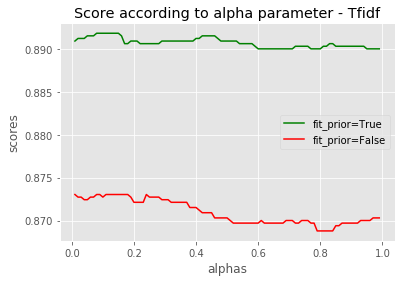

In [308]:
# TESTING PARAMETERS 1

best_alpha = -1
last_score = -1
alphas = []
scores = []
fit_prior = True
print('------------ Testing alphas with fit_prior=True---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_medium = MultinomialNB(alpha=alpha, fit_prior=True)
    nb_classifier_medium.fit(tfidf_train_medium, y_train_medium)
    nb_pred_medium = nb_classifier_medium.predict(tfidf_test_medium)
    score = metrics.accuracy_score(y_test_medium, nb_pred_medium)
    scores.append(score)
    alphas.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')    


# TESTING PARAMETERS 2

alphas2 = []
scores2 = []
print('------------ Testing alphas with fit_prior=False---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_medium = MultinomialNB(alpha=alpha, fit_prior=False)
    nb_classifier_medium.fit(tfidf_train_medium, y_train_medium)
    nb_pred_medium = nb_classifier_medium.predict(tfidf_test_medium)
    score = metrics.accuracy_score(y_test_medium, nb_pred_medium)
    scores2.append(score)
    alphas2.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
        fit_prior = False
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')  
firstplt, = plt.plot(alphas, scores, color='g', label='fit_prior=True')
secondplt, = plt.plot(alphas2, scores2, color='red', label='fit_prior=False')
plt.legend(handles=[firstplt,secondplt])
plt.xlabel('alphas')
plt.ylabel('scores')
plt.title('Score according to alpha parameter - Tfidf')
plt.show()




Best alpha:  0.08


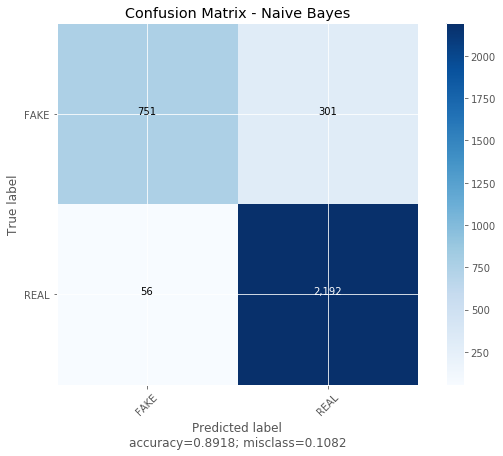

In [310]:
print('\nBest alpha: ', best_alpha)

nb_classifier_medium = MultinomialNB(alpha=best_alpha)

#this will determine the internal parameters based on the dataset.
nb_classifier_medium.fit(tfidf_train_medium, y_train_medium)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred_medium = nb_classifier_medium.predict(tfidf_test_medium)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm_medium = metrics.confusion_matrix(y_test_medium, nb_pred_medium, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm_medium, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - Naive Bayes')

### Using SVM - Tfidf

C: 0.01 Score: 0.68394
C: 0.02 Score: 0.74333
C: 0.03 Score: 0.79909
C: 0.04 Score: 0.83606
C: 0.05 Score: 0.85909
C: 0.06 Score: 0.87424
C: 0.07 Score: 0.88697
C: 0.08 Score: 0.89515
C: 0.09 Score: 0.90212
C: 0.10 Score: 0.90758
C: 0.11 Score: 0.91152
C: 0.12 Score: 0.91242
C: 0.13 Score: 0.91333
C: 0.14 Score: 0.91455
C: 0.15 Score: 0.91515
C: 0.16 Score: 0.91818
C: 0.17 Score: 0.91909
C: 0.18 Score: 0.91909
C: 0.19 Score: 0.91970
C: 0.20 Score: 0.91939
C: 0.21 Score: 0.91939
C: 0.22 Score: 0.92000
C: 0.23 Score: 0.92030
C: 0.24 Score: 0.92061
C: 0.25 Score: 0.92091
C: 0.26 Score: 0.92182
C: 0.27 Score: 0.92242
C: 0.28 Score: 0.92394
C: 0.29 Score: 0.92394
C: 0.30 Score: 0.92273
C: 0.31 Score: 0.92242
C: 0.32 Score: 0.92152
C: 0.33 Score: 0.92182
C: 0.34 Score: 0.92212
C: 0.35 Score: 0.92182
C: 0.36 Score: 0.92212
C: 0.37 Score: 0.92182
C: 0.38 Score: 0.92273
C: 0.39 Score: 0.92303
C: 0.40 Score: 0.92364
C: 0.41 Score: 0.92333
C: 0.42 Score: 0.92333
C: 0.43 Score: 0.92394
C: 0.44 Sco

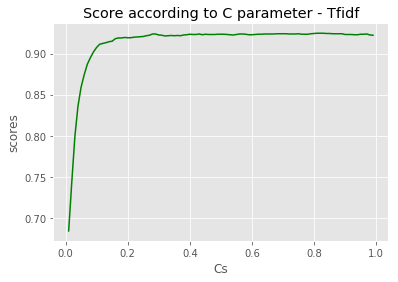

In [316]:
# TESTING PARAMETERS 1

best_C = -1
last_score = -1
Cs = []
scores = []

for C in np.arange(0.01,1,.01):
    svm_classifier_medium = svm.SVC(kernel ='linear', C=C)
    svm_classifier_medium.fit(tfidf_train_medium, y_train_medium)
    svm_pred_medium = svm_classifier_medium.predict(tfidf_test_medium)
    score = metrics.accuracy_score(y_test_medium, svm_pred_medium)
    scores.append(score)
    Cs.append(C)
    if score > last_score:
        last_score = score
        best_C = C
        fit_prior = False
    print("C: {:.2f} Score: {:.5f}".format(C, score))
    
plot_line_chart(Cs, scores, 'Cs', 'scores', 'Score according to C parameter - Tfidf')


Best C:  0.81


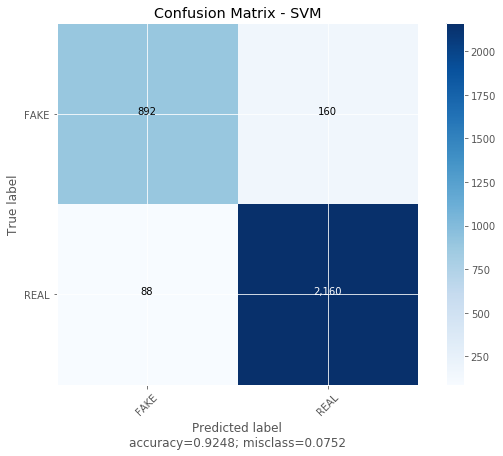

In [317]:
print('\nBest C: ', best_C)

svm_classifier_medium = svm.SVC(kernel ='linear', C=best_C)
svm_classifier_medium.fit(tfidf_train_medium, y_train_medium)
svm_pred_medium = svm_classifier_medium.predict(tfidf_test_medium)
svm_cm_medium = metrics.confusion_matrix(y_test_medium, svm_pred_medium, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm_medium, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - SVM')

### Using CountVectorizer (Bag-of-words)

In [318]:
count_vectorizer_medium = CountVectorizer(stop_words='english', min_df=0.02, max_df=0.6, tokenizer=tokenizer, preprocessor=preprocessor) 
#turns my text into bag-of-words vectors similar to a Gensim corpus
#it also remove english stop words from the plot summaries as a 
#preprocessing step
        
#Each token now acts as a feature for the machine learning classification problem, just like the flowers measurement in 
#the iris dataset

count_train_medium = count_vectorizer_medium.fit_transform(X_train_medium.astype('U')) #Create the bag-of-words vectors
#fit_transform is a handy shortcut which will call the model's fit and then transform methods
#generates a mapping of words with IDs and vectors representing how many times each word appears in the plot
#Operates differently for each model, but generally fit will find parameters or norms in the data and transform 
#will apply the model's underlying algorithm or approximation
#For the CountVectorizer class, fit_transform will create the bag-of-words dictionary and vectors for each document using
#the training data

count_test_medium = count_vectorizer_medium.transform(X_test_medium.astype('U')) #Create bag-of-words vector using the same dictionary

### Using Naive Bayes classifier - CountVectorizer

------------ Testing alphas with fit_prior=True---------------
Alpha: 0.01 Score: 0.86152
Alpha: 0.02 Score: 0.86152
Alpha: 0.03 Score: 0.86152
Alpha: 0.04 Score: 0.86152
Alpha: 0.05 Score: 0.86152
Alpha: 0.06 Score: 0.86152
Alpha: 0.07 Score: 0.86152
Alpha: 0.08 Score: 0.86152
Alpha: 0.09 Score: 0.86152
Alpha: 0.10 Score: 0.86152
Alpha: 0.11 Score: 0.86152
Alpha: 0.12 Score: 0.86152
Alpha: 0.13 Score: 0.86152
Alpha: 0.14 Score: 0.86152
Alpha: 0.15 Score: 0.86152
Alpha: 0.16 Score: 0.86152
Alpha: 0.17 Score: 0.86152
Alpha: 0.18 Score: 0.86152
Alpha: 0.19 Score: 0.86152
Alpha: 0.20 Score: 0.86152
Alpha: 0.21 Score: 0.86152
Alpha: 0.22 Score: 0.86152
Alpha: 0.23 Score: 0.86152
Alpha: 0.24 Score: 0.86152
Alpha: 0.25 Score: 0.86152
Alpha: 0.26 Score: 0.86152
Alpha: 0.27 Score: 0.86152
Alpha: 0.28 Score: 0.86152
Alpha: 0.29 Score: 0.86152
Alpha: 0.30 Score: 0.86152
Alpha: 0.31 Score: 0.86152
Alpha: 0.32 Score: 0.86152
Alpha: 0.33 Score: 0.86152
Alpha: 0.34 Score: 0.86152
Alpha: 0.35 Score: 

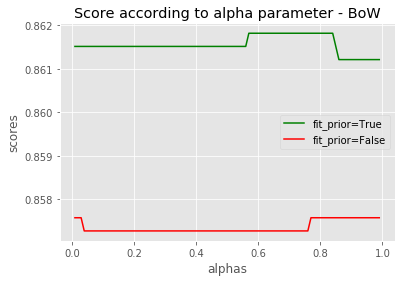

In [319]:
# TESTING PARAMETERS 1

best_alpha = -1
last_score = -1
alphas = []
scores = []
fit_prior = True
print('------------ Testing alphas with fit_prior=True---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_2_medium = MultinomialNB(alpha=alpha, fit_prior=True)
    nb_classifier_2_medium.fit(count_train_medium, y_train_medium)
    nb_pred_2_medium = nb_classifier_2_medium.predict(count_test_medium)
    score = metrics.accuracy_score(y_test_medium, nb_pred_2_medium)
    scores.append(score)
    alphas.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')    


# TESTING PARAMETERS 2

alphas2 = []
scores2 = []
print('------------ Testing alphas with fit_prior=False---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_2_medium = MultinomialNB(alpha=alpha, fit_prior=False)
    nb_classifier_2_medium.fit(count_train_medium, y_train_medium)
    nb_pred_2_medium = nb_classifier_2_medium.predict(count_test_medium)
    score = metrics.accuracy_score(y_test_medium, nb_pred_2_medium)
    scores2.append(score)
    alphas2.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
        fit_prior = False
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')  
firstplt, = plt.plot(alphas, scores, color='g', label='fit_prior=True')
secondplt, = plt.plot(alphas2, scores2, color='red', label='fit_prior=False')
plt.legend(handles=[firstplt,secondplt])
plt.xlabel('alphas')
plt.ylabel('scores')
plt.title('Score according to alpha parameter - BoW')
plt.show()




Best alpha:  0.5700000000000001


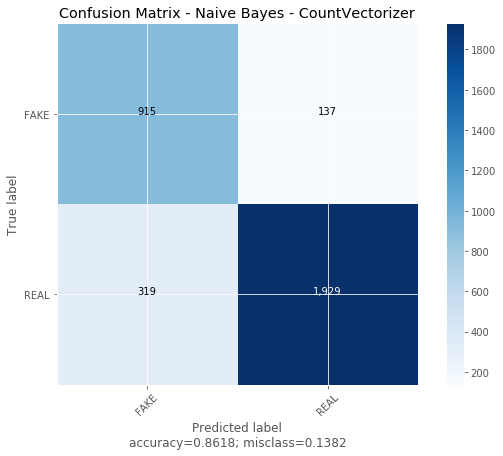

In [320]:
print('\nBest alpha: ', best_alpha)

nb_classifier_2_medium = MultinomialNB(alpha=best_alpha)

#this will determine the internal parameters based on the dataset.
nb_classifier_2_medium.fit(count_train_medium, y_train_medium)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred_2_medium = nb_classifier_2_medium.predict(count_test_medium)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm_2_medium = metrics.confusion_matrix(y_test_medium, nb_pred_2_medium, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm_2_medium, normalize=False, target_names=['FAKE', 'REAL'],
                      title = 'Confusion Matrix - Naive Bayes - CountVectorizer')

### Using SVM - CountVectorizer

C: 0.01 Score: 0.91212
C: 0.02 Score: 0.90727
C: 0.03 Score: 0.90545
C: 0.04 Score: 0.90636
C: 0.05 Score: 0.90636
C: 0.06 Score: 0.90606
C: 0.07 Score: 0.90424
C: 0.08 Score: 0.90424
C: 0.09 Score: 0.90515
C: 0.10 Score: 0.90333
C: 0.11 Score: 0.90303
C: 0.12 Score: 0.90394
C: 0.13 Score: 0.90424
C: 0.14 Score: 0.90485
C: 0.15 Score: 0.90515
C: 0.16 Score: 0.90515
C: 0.17 Score: 0.90455
C: 0.18 Score: 0.90364
C: 0.19 Score: 0.90242
C: 0.20 Score: 0.90212
C: 0.21 Score: 0.90030
C: 0.22 Score: 0.90091
C: 0.23 Score: 0.89939
C: 0.24 Score: 0.89939
C: 0.25 Score: 0.89818
C: 0.26 Score: 0.89848
C: 0.27 Score: 0.89818
C: 0.28 Score: 0.89758
C: 0.29 Score: 0.89848
C: 0.30 Score: 0.90061
C: 0.31 Score: 0.90030
C: 0.32 Score: 0.89909
C: 0.33 Score: 0.89970
C: 0.34 Score: 0.89970
C: 0.35 Score: 0.89879
C: 0.36 Score: 0.89879
C: 0.37 Score: 0.89848
C: 0.38 Score: 0.89909
C: 0.39 Score: 0.89879
C: 0.40 Score: 0.89909
C: 0.41 Score: 0.89939
C: 0.42 Score: 0.89909
C: 0.43 Score: 0.89879
C: 0.44 Sco

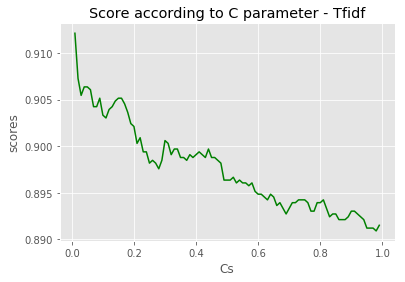

In [321]:
# TESTING PARAMETERS 1

best_C = -1
last_score = -1
Cs = []
scores = []

for C in np.arange(0.01,1,.01):
    svm_classifier_2_medium = svm.SVC(kernel ='linear', C=C)
    svm_classifier_2_medium.fit(count_train_medium, y_train_medium)
    svm_pred_2_medium = svm_classifier_2_medium.predict(count_test_medium)
    score = metrics.accuracy_score(y_test_medium, svm_pred_2_medium)
    scores.append(score)
    Cs.append(C)
    if score > last_score:
        last_score = score
        best_C = C
        fit_prior = False
    print("C: {:.2f} Score: {:.5f}".format(C, score))
    
plot_line_chart(Cs, scores, 'Cs', 'scores', 'Score according to C parameter - Tfidf')


Best C:  0.01


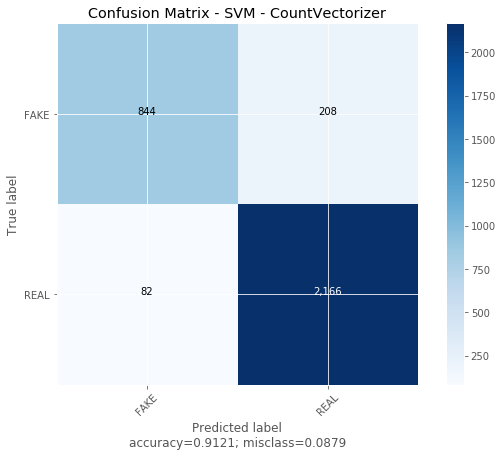

In [322]:
print('\nBest C: ', best_C)

svm_classifier_2_medium = svm.SVC(kernel ='linear', C=best_C)
svm_classifier_2_medium.fit(count_train_medium, y_train_medium)
svm_pred_2_medium = svm_classifier_2_medium.predict(count_test_medium)
svm_cm_2_medium = metrics.confusion_matrix(y_test_medium, svm_pred_2_medium, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm_2_medium, normalize=False, target_names=['FAKE', 'REAL'],
                      title = 'Confusion Matrix - SVM - CountVectorizer')

### Keras

In [14]:
# integer encode
#transform y values into 0s and 1s
label_encoder_medium = LabelEncoder()
integer_encoded_train_medium = label_encoder_medium.fit_transform(y_train_medium.values)
integer_encoded_test_medium = label_encoder_medium.fit_transform(y_test_medium.values)
print(integer_encoded_train_medium)
'''
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)
onehot_encoded_test = onehot_encoder.fit_transform(integer_encoded_test)
print(onehot_encoded_train)
'''

[1 1 1 ... 0 1 1]


'\n# binary encode\nonehot_encoder = OneHotEncoder(sparse=False)\ninteger_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)\ninteger_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)\nonehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)\nonehot_encoded_test = onehot_encoder.fit_transform(integer_encoded_test)\nprint(onehot_encoded_train)\n'

### Word Embeddings

In [15]:
tokenizer_medium = Tokenizer()
tokenizer_medium.fit_on_texts(X_train_medium)

#return a list of sequences (one per text input)
X_2_train_medium = tokenizer_medium.texts_to_sequences(X_train_medium.astype('U'))

X_2_test_medium = tokenizer_medium.texts_to_sequences(X_test_medium.astype('U'))

vocab_size_medium = len(tokenizer_medium.word_index) + 1 #adding 1 because of reserved 0 index

maxlen_medium = 0
for sequence in X_2_train_medium:
    if len(sequence) > maxlen_medium:
        maxlen_medium = len(sequence)


#avoid the problem that each text sequence has different length of words
X_2_train_medium = pad_sequences(X_2_train_medium, padding='post', maxlen=maxlen_medium) #pads the sequence of words with zeros
X_2_test_medium = pad_sequences(X_2_test_medium, padding='post', maxlen=maxlen_medium) #pads the sequence of words with zeros


### Using Convolutional Neural Network

In [82]:
embedding_dim_medium = 100

model_medium = Sequential()
model_medium.add(layers.Embedding(input_dim=vocab_size_medium, output_dim=embedding_dim_medium, input_length=maxlen_medium))
model_medium.add(layers.Conv1D(128, 5, activation='relu'))
model_medium.add(layers.GlobalMaxPool1D())
model_medium.add(layers.Dense(10, activation='relu'))
model_medium.add(layers.Dense(1, activation='sigmoid'))
model_medium.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_medium.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 18386, 100)        10989200  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 18382, 128)        64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 11,054,629
Trainable params: 11,054,629
Non-trainable params: 0
_________________________________________________________________


In [83]:
history_medium = model_medium.fit(X_2_train_medium, integer_encoded_train_medium,
                    epochs=3,
                    verbose=1,
                    validation_data=(X_2_test_medium, integer_encoded_test_medium),
                    batch_size=50) #batch_size >= 150 pc stops working

Train on 6700 samples, validate on 3300 samples
Epoch 1/3
6700/6700 [==============================] - ETA: 34:44 - loss: 0.7067 - acc: 0.22 - ETA: 34:23 - loss: 0.7033 - acc: 0.26 - ETA: 33:46 - loss: 0.7010 - acc: 0.29 - ETA: 33:17 - loss: 0.6994 - acc: 0.31 - ETA: 32:37 - loss: 0.6979 - acc: 0.36 - ETA: 31:58 - loss: 0.6963 - acc: 0.44 - ETA: 31:25 - loss: 0.6950 - acc: 0.48 - ETA: 31:12 - loss: 0.6938 - acc: 0.50 - ETA: 31:08 - loss: 0.6927 - acc: 0.52 - ETA: 31:08 - loss: 0.6908 - acc: 0.55 - ETA: 31:08 - loss: 0.6898 - acc: 0.56 - ETA: 31:10 - loss: 0.6889 - acc: 0.57 - ETA: 31:16 - loss: 0.6882 - acc: 0.57 - ETA: 31:09 - loss: 0.6875 - acc: 0.57 - ETA: 30:58 - loss: 0.6860 - acc: 0.58 - ETA: 30:55 - loss: 0.6844 - acc: 0.59 - ETA: 30:41 - loss: 0.6827 - acc: 0.60 - ETA: 30:32 - loss: 0.6815 - acc: 0.61 - ETA: 30:21 - loss: 0.6807 - acc: 0.61 - ETA: 30:13 - loss: 0.6794 - acc: 0.61 - ETA: 30:16 - loss: 0.6781 - acc: 0.62 - ETA: 30:10 - loss: 0.6764 - acc: 0.62 - ETA: 29:55 - loss

6700/6700 [==============================] - ETA: 33:33 - loss: 0.0108 - acc: 1.00 - ETA: 33:45 - loss: 0.0131 - acc: 1.00 - ETA: 33:35 - loss: 0.0124 - acc: 1.00 - ETA: 33:14 - loss: 0.0135 - acc: 1.00 - ETA: 32:57 - loss: 0.0119 - acc: 1.00 - ETA: 32:44 - loss: 0.0133 - acc: 1.00 - ETA: 32:24 - loss: 0.0145 - acc: 1.00 - ETA: 32:03 - loss: 0.0178 - acc: 0.99 - ETA: 31:45 - loss: 0.0168 - acc: 0.99 - ETA: 31:29 - loss: 0.0163 - acc: 0.99 - ETA: 31:11 - loss: 0.0183 - acc: 0.99 - ETA: 30:53 - loss: 0.0175 - acc: 0.99 - ETA: 30:36 - loss: 0.0175 - acc: 0.99 - ETA: 30:22 - loss: 0.0175 - acc: 0.99 - ETA: 30:07 - loss: 0.0167 - acc: 0.99 - ETA: 29:51 - loss: 0.0165 - acc: 0.99 - ETA: 29:36 - loss: 0.0159 - acc: 0.99 - ETA: 29:22 - loss: 0.0179 - acc: 0.99 - ETA: 29:08 - loss: 0.0177 - acc: 0.99 - ETA: 28:53 - loss: 0.0173 - acc: 0.99 - ETA: 28:38 - loss: 0.0167 - acc: 0.99 - ETA: 28:23 - loss: 0.0162 - acc: 0.99 - ETA: 28:06 - loss: 0.0158 - acc: 0.99 - ETA: 27:50 - loss: 0.0154 - acc: 0.

Training Accuracy: 1.0000
Testing Accuracy:  0.9706


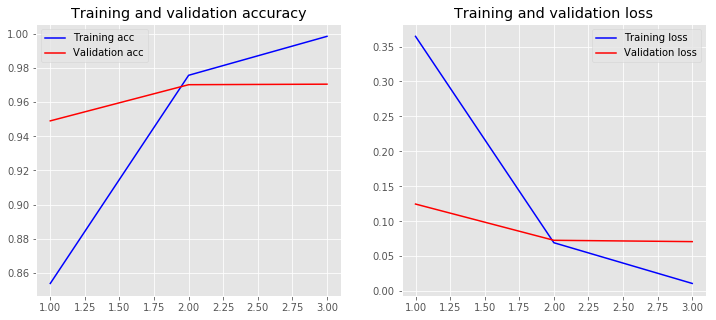

In [84]:
loss, accuracy = model_medium.evaluate(X_2_train_medium, integer_encoded_train_medium, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_medium.evaluate(X_2_test_medium, integer_encoded_test_medium, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_medium)

3300/3300 [==============================] - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 53 - ETA: 49 - ETA: 44 - ETA: 40 - ETA: 35 - ETA: 31 - ETA: 26 - ETA: 22 - ETA: 17 - ETA: 13 - ETA: 8 - ETA:  - 296s 90ms/step


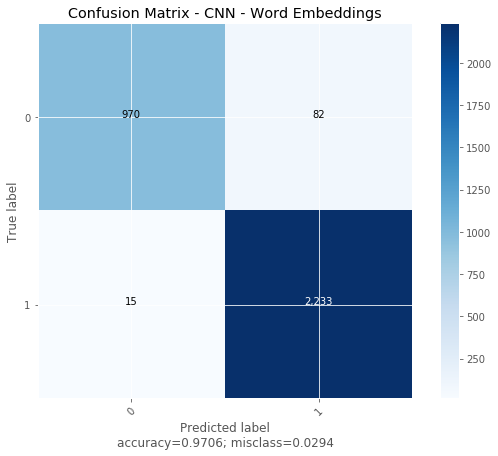

In [85]:
keras_pred_medium = model_medium.predict_classes(X_2_test_medium, batch_size=50, verbose=1)
keras_cm_medium = metrics.confusion_matrix(integer_encoded_test_medium, keras_pred_medium, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm_medium, normalize=False, target_names=[0, 1],
                      title = 'Confusion Matrix - CNN - Word Embeddings')

### Using Recurrent Neural Network

In [ ]:
embedding_dim2_medium = 100

model2_medium = Sequential()
model2_medium.add(layers.Embedding(input_dim=vocab_size_medium, output_dim=embedding_dim2_medium, input_length=maxlen_medium))
model2_medium.add(layers.LSTM(128))
model2_medium.add(layers.Dense(10, activation='relu'))
model2_medium.add(layers.Dense(1, activation='sigmoid'))
model2_medium.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2_medium.summary())


In [ ]:
history_medium = model2_medium.fit(X_2_train_medium, integer_encoded_train_medium,
                    epochs=3,
                    verbose=1,
                    validation_data=(X_2_test_medium, integer_encoded_test_medium),
                    batch_size=100) #batch_size >= 150 pc stops working


In [ ]:
keras_pred2_medium = model2_medium.predict_classes(X_2_test_medium, batch_size=50, verbose=1)
keras_cm2_medium = metrics.confusion_matrix(integer_encoded_test_medium, keras_pred2_medium, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm2_medium, normalize=False, target_names=[0, 1],
                      title = 'Confusion Matrix - RNN - Word Embeddings')

## News Cleaned - Large (100.000 datas)

## Some preprocessing functions

In [323]:
spacy.load('en')
lemmatizer = spacy.lang.en.English()

# remove html entities from docs and
# set everything to lowercase
def preprocessor(doc):
    return(unescape(doc).lower())
# tokenize the doc and lemmatize its tokens
def tokenizer(doc):
    tokens = lemmatizer(doc)
    #When I use this code the accuracy decreases
    tokens = [token for token in tokens if token.is_ascii and token.is_alpha]
    return([token.lemma_ for token in tokens])

In [324]:
y_large = df_news_cleaned_large.type

#getting the training and test sets
X_train_large, X_test_large, y_train_large, y_test_large = train_test_split(df_news_cleaned_large.content,
                                                                                y_large, test_size =0.33, random_state=53)

### Using Tfidf

In [325]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer_large = TfidfVectorizer(stop_words="english", min_df=0.02, max_df=0.6, tokenizer=tokenizer, preprocessor=preprocessor)

# Transform the training data: tfidf_train 
tfidf_train_large = tfidf_vectorizer_large.fit_transform(X_train_large.astype('U'))

# Transform the test data: tfidf_test 
tfidf_test_large = tfidf_vectorizer_large.transform(X_test_large.astype('U'))

### Using Naive Bayes classifier - Tfidf

------------ Testing alphas with fit_prior=True---------------
Alpha: 0.01 Score: 0.88776
Alpha: 0.02 Score: 0.88776
Alpha: 0.03 Score: 0.88776
Alpha: 0.04 Score: 0.88776
Alpha: 0.05 Score: 0.88776
Alpha: 0.06 Score: 0.88779
Alpha: 0.07 Score: 0.88779
Alpha: 0.08 Score: 0.88779
Alpha: 0.09 Score: 0.88779
Alpha: 0.10 Score: 0.88779
Alpha: 0.11 Score: 0.88779
Alpha: 0.12 Score: 0.88779
Alpha: 0.13 Score: 0.88779
Alpha: 0.14 Score: 0.88779
Alpha: 0.15 Score: 0.88776
Alpha: 0.16 Score: 0.88776
Alpha: 0.17 Score: 0.88776
Alpha: 0.18 Score: 0.88776
Alpha: 0.19 Score: 0.88776
Alpha: 0.20 Score: 0.88779
Alpha: 0.21 Score: 0.88779
Alpha: 0.22 Score: 0.88779
Alpha: 0.23 Score: 0.88779
Alpha: 0.24 Score: 0.88776
Alpha: 0.25 Score: 0.88776
Alpha: 0.26 Score: 0.88776
Alpha: 0.27 Score: 0.88776
Alpha: 0.28 Score: 0.88779
Alpha: 0.29 Score: 0.88779
Alpha: 0.30 Score: 0.88779
Alpha: 0.31 Score: 0.88776
Alpha: 0.32 Score: 0.88779
Alpha: 0.33 Score: 0.88782
Alpha: 0.34 Score: 0.88782
Alpha: 0.35 Score: 

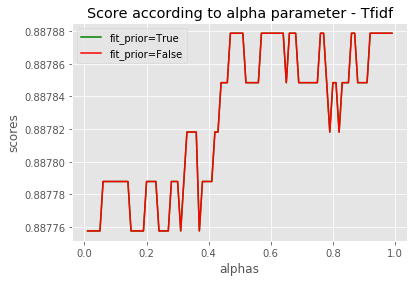

In [326]:
# TESTING PARAMETERS 1

best_alpha = -1
last_score = -1
alphas = []
scores = []
fit_prior = True
print('------------ Testing alphas with fit_prior=True---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_large = MultinomialNB(alpha=alpha,  fit_prior=True)
    nb_classifier_large.fit(tfidf_train_large, y_train_large)
    nb_pred_large = nb_classifier_large.predict(tfidf_test_large)
    score = metrics.accuracy_score(y_test_large, nb_pred_large)
    scores.append(score)
    alphas.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')    


# TESTING PARAMETERS 2

alphas2 = []
scores2 = []
print('------------ Testing alphas with fit_prior=False---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_large = MultinomialNB(alpha=alpha,  fit_prior=True)
    nb_classifier_large.fit(tfidf_train_large, y_train_large)
    nb_pred_large = nb_classifier_large.predict(tfidf_test_large)
    score = metrics.accuracy_score(y_test_large, nb_pred_large)
    scores2.append(score)
    alphas2.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
        fit_prior = False
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')  
firstplt, = plt.plot(alphas, scores, color='g', label='fit_prior=True')
secondplt, = plt.plot(alphas2, scores2, color='red', label='fit_prior=False')
plt.legend(handles=[firstplt,secondplt])
plt.xlabel('alphas')
plt.ylabel('scores')
plt.title('Score according to alpha parameter - Tfidf')
plt.show()




Best alpha:  0.47000000000000003


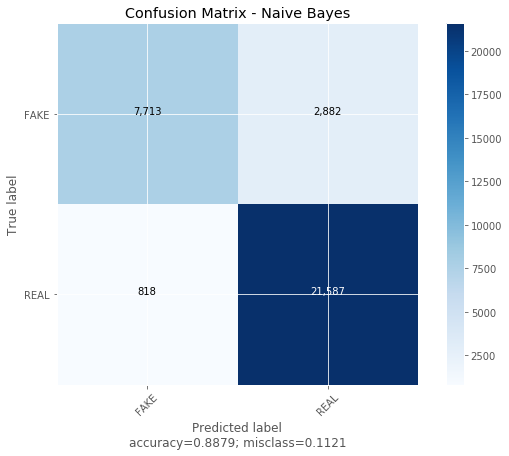

In [327]:
print('\nBest alpha: ', best_alpha)

nb_classifier_large = MultinomialNB(alpha=best_alpha)

#this will determine the internal parameters based on the dataset.
nb_classifier_large.fit(tfidf_train_large, y_train_large)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred_large = nb_classifier_large.predict(tfidf_test_large)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm_large = metrics.confusion_matrix(y_test_large, nb_pred_large, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm_large, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - Naive Bayes')

### Using SVM - Tfidf

C: 0.01 Score: 0.90339
C: 0.02 Score: 0.92155
C: 0.03 Score: 0.92591
C: 0.04 Score: 0.92797
C: 0.05 Score: 0.92967
C: 0.06 Score: 0.93100
C: 0.07 Score: 0.93267
C: 0.08 Score: 0.93300
C: 0.09 Score: 0.93373
C: 0.10 Score: 0.93394
C: 0.11 Score: 0.93467
C: 0.12 Score: 0.93527
C: 0.13 Score: 0.93548
C: 0.14 Score: 0.93579
C: 0.15 Score: 0.93624
C: 0.16 Score: 0.93642
C: 0.17 Score: 0.93673
C: 0.18 Score: 0.93673
C: 0.19 Score: 0.93670
C: 0.20 Score: 0.93685
C: 0.21 Score: 0.93697
C: 0.22 Score: 0.93712
C: 0.23 Score: 0.93715
C: 0.24 Score: 0.93721
C: 0.25 Score: 0.93730
C: 0.26 Score: 0.93727
C: 0.27 Score: 0.93739
C: 0.28 Score: 0.93770
C: 0.29 Score: 0.93785
C: 0.30 Score: 0.93800
C: 0.31 Score: 0.93803
C: 0.32 Score: 0.93806
C: 0.33 Score: 0.93827
C: 0.34 Score: 0.93852
C: 0.35 Score: 0.93818
C: 0.36 Score: 0.93815
C: 0.37 Score: 0.93821
C: 0.38 Score: 0.93815
C: 0.39 Score: 0.93824
C: 0.40 Score: 0.93836
C: 0.41 Score: 0.93861
C: 0.42 Score: 0.93867
C: 0.43 Score: 0.93906
C: 0.44 Sco

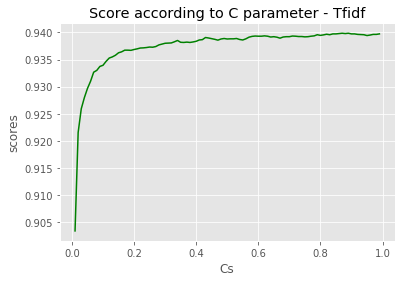

In [328]:
# TESTING PARAMETERS 1

best_C = -1
last_score = -1
Cs = []
scores = []

for C in np.arange(0.01,1,.01):
    svm_classifier_large = svm.SVC(kernel ='linear', C=C)
    svm_classifier_large.fit(tfidf_train_large, y_train_large)
    svm_pred_large = svm_classifier_large.predict(tfidf_test_large)
    score = metrics.accuracy_score(y_test_large, svm_pred_large)
    scores.append(score)
    Cs.append(C)
    if score > last_score:
        last_score = score
        best_C = C
        fit_prior = False
    print("C: {:.2f} Score: {:.5f}".format(C, score))
    
plot_line_chart(Cs, scores, 'Cs', 'scores', 'Score according to C parameter - Tfidf')


Best C:  0.87


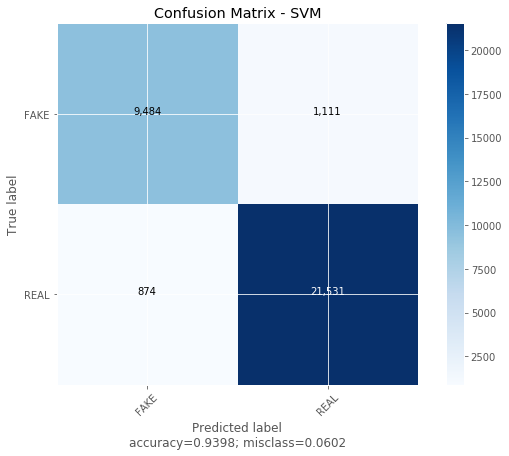

In [329]:
print('\nBest C: ', best_C)

svm_classifier_large = svm.SVC(kernel ='linear', C=best_C)
svm_classifier_large.fit(tfidf_train_large, y_train_large)
svm_pred_large = svm_classifier_large.predict(tfidf_test_large)
svm_cm_large = metrics.confusion_matrix(y_test_large, svm_pred_large, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm_large, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - SVM')

### Using CountVectorizer (Bag-of-words)

In [330]:
count_vectorizer_large = CountVectorizer(stop_words='english', min_df=0.02, max_df=0.6, tokenizer=tokenizer, preprocessor=preprocessor) 
#turns my text into bag-of-words vectors similar to a Gensim corpus
#it also remove english stop words from the plot summaries as a 
#preprocessing step
        
#Each token now acts as a feature for the machine learning classification problem, just like the flowers measurement in 
#the iris dataset

count_train_large = count_vectorizer_large.fit_transform(X_train_large.astype('U')) #Create the bag-of-words vectors
#fit_transform is a handy shortcut which will call the model's fit and then transform methods
#generates a mapping of words with IDs and vectors representing how many times each word appears in the plot
#Operates differently for each model, but generally fit will find parameters or norms in the data and transform 
#will apply the model's underlying algorithm or approximation
#For the CountVectorizer class, fit_transform will create the bag-of-words dictionary and vectors for each document using
#the training data

count_test_large = count_vectorizer_large.transform(X_test_large.astype('U')) #Create bag-of-words vector using the same dictionary

### Using Naive Bayes classifier - CountVectorizer

------------ Testing alphas with fit_prior=True---------------
Alpha: 0.01 Score: 0.85812
Alpha: 0.02 Score: 0.85812
Alpha: 0.03 Score: 0.85812
Alpha: 0.04 Score: 0.85812
Alpha: 0.05 Score: 0.85812
Alpha: 0.06 Score: 0.85812
Alpha: 0.07 Score: 0.85812
Alpha: 0.08 Score: 0.85812
Alpha: 0.09 Score: 0.85812
Alpha: 0.10 Score: 0.85812
Alpha: 0.11 Score: 0.85812
Alpha: 0.12 Score: 0.85812
Alpha: 0.13 Score: 0.85812
Alpha: 0.14 Score: 0.85812
Alpha: 0.15 Score: 0.85812
Alpha: 0.16 Score: 0.85809
Alpha: 0.17 Score: 0.85809
Alpha: 0.18 Score: 0.85809
Alpha: 0.19 Score: 0.85809
Alpha: 0.20 Score: 0.85809
Alpha: 0.21 Score: 0.85809
Alpha: 0.22 Score: 0.85809
Alpha: 0.23 Score: 0.85809
Alpha: 0.24 Score: 0.85809
Alpha: 0.25 Score: 0.85809
Alpha: 0.26 Score: 0.85809
Alpha: 0.27 Score: 0.85809
Alpha: 0.28 Score: 0.85809
Alpha: 0.29 Score: 0.85809
Alpha: 0.30 Score: 0.85809
Alpha: 0.31 Score: 0.85809
Alpha: 0.32 Score: 0.85809
Alpha: 0.33 Score: 0.85809
Alpha: 0.34 Score: 0.85809
Alpha: 0.35 Score: 

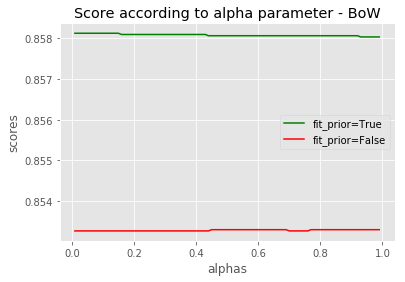

In [331]:
# TESTING PARAMETERS 1

best_alpha = -1
last_score = -1
alphas = []
scores = []
fit_prior = True
print('------------ Testing alphas with fit_prior=True---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_2_large = MultinomialNB(alpha=alpha, fit_prior=True)
    nb_classifier_2_large.fit(count_train_large, y_train_large)
    nb_pred_2_large = nb_classifier_2_large.predict(count_test_large)
    score = metrics.accuracy_score(y_test_large, nb_pred_2_large)
    scores.append(score)
    alphas.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')    


# TESTING PARAMETERS 2

alphas2 = []
scores2 = []
print('------------ Testing alphas with fit_prior=False---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_2_large = MultinomialNB(alpha=alpha, fit_prior=False)
    nb_classifier_2_large.fit(count_train_large, y_train_large)
    nb_pred_2_large = nb_classifier_2_large.predict(count_test_large)
    score = metrics.accuracy_score(y_test_large, nb_pred_2_large)
    scores2.append(score)
    alphas2.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
        fit_prior = False
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')  
firstplt, = plt.plot(alphas, scores, color='g', label='fit_prior=True')
secondplt, = plt.plot(alphas2, scores2, color='red', label='fit_prior=False')
plt.legend(handles=[firstplt,secondplt])
plt.xlabel('alphas')
plt.ylabel('scores')
plt.title('Score according to alpha parameter - BoW')
plt.show()




Best alpha:  0.01


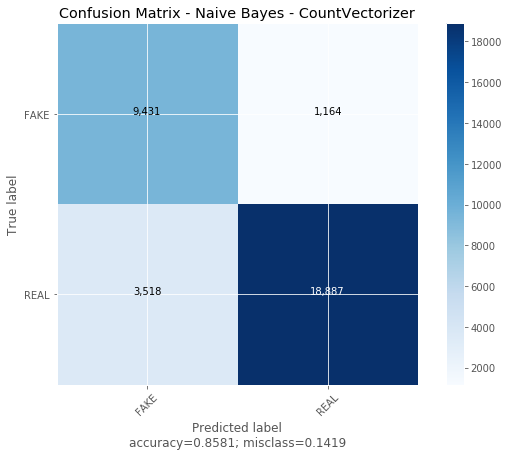

In [332]:
print('\nBest alpha: ', best_alpha)

nb_classifier_2_large = MultinomialNB(alpha=best_alpha)

#this will determine the internal parameters based on the dataset.
nb_classifier_2_large.fit(count_train_large, y_train_large)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred_2_large = nb_classifier_2_large.predict(count_test_large)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm_2_large = metrics.confusion_matrix(y_test_large, nb_pred_2_large, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm_2_large, normalize=False, target_names=['FAKE', 'REAL'],
                      title = 'Confusion Matrix - Naive Bayes - CountVectorizer')

### Using SVM - CountVectorizer

In [ ]:
# TESTING PARAMETERS 1

best_C = -1
last_score = -1
Cs = []
scores = []

for C in np.arange(0.01,1,.01):
    svm_classifier_2_large = svm.SVC(kernel ='linear', C=C)
    svm_classifier_2_large.fit(count_train_large, y_train_large)
    svm_pred_2_large = svm_classifier_2_large.predict(count_test_large)
    score = metrics.accuracy_score(y_test_large, svm_pred_2_large)
    scores.append(score)
    Cs.append(C)
    if score > last_score:
        last_score = score
        best_C = C
        fit_prior = False
    print("C: {:.2f} Score: {:.5f}".format(C, score))
    
plot_line_chart(Cs, scores, 'Cs', 'scores', 'Score according to C parameter - BoW')

C: 0.01 Score: 0.93121
C: 0.02 Score: 0.93112
C: 0.03 Score: 0.93139
C: 0.04 Score: 0.93139
C: 0.05 Score: 0.93079
C: 0.06 Score: 0.93106
C: 0.07 Score: 0.93082
C: 0.08 Score: 0.93088
C: 0.09 Score: 0.93103
C: 0.10 Score: 0.93079
C: 0.11 Score: 0.93091
C: 0.12 Score: 0.93085
C: 0.13 Score: 0.93061
C: 0.14 Score: 0.93076
C: 0.15 Score: 0.93079
C: 0.16 Score: 0.93085
C: 0.17 Score: 0.93085
C: 0.18 Score: 0.93091
C: 0.19 Score: 0.93082
C: 0.20 Score: 0.93085
C: 0.21 Score: 0.93070
C: 0.22 Score: 0.93070
C: 0.23 Score: 0.93058
C: 0.24 Score: 0.93061


In [ ]:
print('\nBest C: ', best_C)

svm_classifier_2_large = svm.SVC(kernel ='linear', C=best_C)
svm_classifier_2_large.fit(count_train_large, y_train_large)
svm_pred_2_large = svm_classifier_2_large.predict(count_test_large)
svm_cm_2_large = metrics.confusion_matrix(y_test_large, svm_pred_2_large, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm_2_large, normalize=False, target_names=['FAKE', 'REAL'],
                      title = 'Confusion Matrix - SVM - CountVectorizer')

### Keras

In [19]:
# integer encode
#transform y values into 0s and 1s
label_encoder_large = LabelEncoder()
integer_encoded_train_large = label_encoder_large.fit_transform(y_train_large.values)
integer_encoded_test_large = label_encoder_large.fit_transform(y_test_large.values)
print(integer_encoded_train_large)
'''
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)
onehot_encoded_test = onehot_encoder.fit_transform(integer_encoded_test)
print(onehot_encoded_train)
'''

[1 1 0 ... 1 1 1]


'\n# binary encode\nonehot_encoder = OneHotEncoder(sparse=False)\ninteger_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)\ninteger_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)\nonehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)\nonehot_encoded_test = onehot_encoder.fit_transform(integer_encoded_test)\nprint(onehot_encoded_train)\n'

### Word Embeddings

In [20]:
tokenizer_large = Tokenizer()
tokenizer_large.fit_on_texts(X_train_large)

In [21]:
#return a list of sequences (one per text input)
X_2_train_large = tokenizer_large.texts_to_sequences(X_train_large.astype('U'))

X_2_test_large = tokenizer_large.texts_to_sequences(X_test_large.astype('U'))

In [22]:
vocab_size_large = len(tokenizer_large.word_index) + 1 #adding 1 because of reserved 0 index

In [14]:
maxlen_large = 0
for sequence in X_2_train_large:
    if len(sequence) > maxlen_large:
        maxlen_large = len(sequence)

In [23]:
X_2_train_large = pad_sequences(X_2_train_large, padding='post', maxlen=8000) #pads the sequence of words with zeros

In [24]:
X_2_test_large = pad_sequences(X_2_test_large, padding='post', maxlen=8000) #pads the sequence of words with zeros

### Using Convolutional Neural Network

In [25]:
embedding_dim_large = 100

model_large = Sequential()
model_large.add(layers.Embedding(input_dim=vocab_size_large, output_dim=embedding_dim_large, input_length=8000))
model_large.add(layers.Conv1D(128, 5, activation='relu'))
model_large.add(layers.GlobalMaxPool1D())
model_large.add(layers.Dense(10, activation='relu'))
model_large.add(layers.Dense(1, activation='sigmoid'))
model_large.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_large.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8000, 100)         40384200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7996, 128)         64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 40,449,629
Trainable params: 40,449,629
Non-trainable params: 0
_________________________________________________________________


In [27]:
history_large = model_large.fit(X_2_train_large, integer_encoded_train_large,
                    epochs=3,
                    verbose=1,
                    validation_data=(X_2_test_large, integer_encoded_test_large),
                    batch_size=50) #batch_size >= 150 pc stops working

Train on 67000 samples, validate on 33000 samples
Epoch 1/3


 9650/67000 [===>..........................] - ETA: 8:38:43 - loss: 0.7221 - acc: 0.30 - ETA: 5:28:46 - loss: 0.7146 - acc: 0.29 - ETA: 4:25:10 - loss: 0.7085 - acc: 0.32 - ETA: 3:53:09 - loss: 0.7045 - acc: 0.37 - ETA: 3:34:09 - loss: 0.7020 - acc: 0.43 - ETA: 3:21:42 - loss: 0.7001 - acc: 0.50 - ETA: 3:13:16 - loss: 0.6988 - acc: 0.54 - ETA: 3:06:38 - loss: 0.6977 - acc: 0.57 - ETA: 3:02:48 - loss: 0.6970 - acc: 0.58 - ETA: 3:01:02 - loss: 0.6964 - acc: 0.59 - ETA: 2:59:03 - loss: 0.6957 - acc: 0.61 - ETA: 2:57:12 - loss: 0.6948 - acc: 0.62 - ETA: 2:55:26 - loss: 0.6942 - acc: 0.63 - ETA: 2:53:44 - loss: 0.6935 - acc: 0.64 - ETA: 2:52:21 - loss: 0.6924 - acc: 0.66 - ETA: 2:51:04 - loss: 0.6916 - acc: 0.67 - ETA: 2:49:53 - loss: 0.6901 - acc: 0.69 - ETA: 2:48:45 - loss: 0.6888 - acc: 0.69 - ETA: 2:47:45 - loss: 0.6871 - acc: 0.70 - ETA: 2:46:45 - loss: 0.6857 - acc: 0.71 - ETA: 2:45:53 - loss: 0.6843 - acc: 0.72 - ETA: 2:45:07 - loss: 0.6831 - acc: 0.72 - ETA: 2:44:31 - loss: 0.6810 -

48700/67000 [====================>.........] - ETA: 1:09:37 - loss: 0.1285 - acc: 0.95 - ETA: 1:09:30 - loss: 0.1284 - acc: 0.95 - ETA: 1:09:22 - loss: 0.1283 - acc: 0.95 - ETA: 1:09:14 - loss: 0.1281 - acc: 0.95 - ETA: 1:09:07 - loss: 0.1280 - acc: 0.95 - ETA: 1:08:59 - loss: 0.1279 - acc: 0.95 - ETA: 1:08:51 - loss: 0.1279 - acc: 0.95 - ETA: 1:08:44 - loss: 0.1278 - acc: 0.95 - ETA: 1:08:36 - loss: 0.1277 - acc: 0.95 - ETA: 1:08:28 - loss: 0.1276 - acc: 0.95 - ETA: 1:08:21 - loss: 0.1275 - acc: 0.95 - ETA: 1:08:13 - loss: 0.1273 - acc: 0.95 - ETA: 1:08:05 - loss: 0.1272 - acc: 0.95 - ETA: 1:07:58 - loss: 0.1271 - acc: 0.95 - ETA: 1:07:51 - loss: 0.1270 - acc: 0.95 - ETA: 1:07:43 - loss: 0.1269 - acc: 0.95 - ETA: 1:07:36 - loss: 0.1267 - acc: 0.95 - ETA: 1:07:28 - loss: 0.1266 - acc: 0.95 - ETA: 1:07:20 - loss: 0.1265 - acc: 0.95 - ETA: 1:07:13 - loss: 0.1263 - acc: 0.95 - ETA: 1:07:05 - loss: 0.1262 - acc: 0.95 - ETA: 1:06:57 - loss: 0.1262 - acc: 0.95 - ETA: 1:06:50 - loss: 0.1261 -

58400/67000 [=========================>....] - ETA: 3:33:13 - loss: 0.1108 - acc: 0.96 - ETA: 3:32:28 - loss: 0.1107 - acc: 0.96 - ETA: 3:31:42 - loss: 0.1106 - acc: 0.96 - ETA: 3:30:57 - loss: 0.1105 - acc: 0.96 - ETA: 3:30:11 - loss: 0.1105 - acc: 0.96 - ETA: 3:29:26 - loss: 0.1105 - acc: 0.96 - ETA: 3:28:41 - loss: 0.1104 - acc: 0.96 - ETA: 3:27:56 - loss: 0.1103 - acc: 0.96 - ETA: 3:27:11 - loss: 0.1102 - acc: 0.96 - ETA: 3:26:26 - loss: 0.1102 - acc: 0.96 - ETA: 3:25:42 - loss: 0.1101 - acc: 0.96 - ETA: 3:24:57 - loss: 0.1100 - acc: 0.96 - ETA: 3:24:12 - loss: 0.1100 - acc: 0.96 - ETA: 3:23:28 - loss: 0.1099 - acc: 0.96 - ETA: 3:22:43 - loss: 0.1099 - acc: 0.96 - ETA: 3:21:59 - loss: 0.1098 - acc: 0.96 - ETA: 3:21:14 - loss: 0.1098 - acc: 0.96 - ETA: 3:20:30 - loss: 0.1097 - acc: 0.96 - ETA: 3:19:46 - loss: 0.1096 - acc: 0.96 - ETA: 3:19:01 - loss: 0.1095 - acc: 0.96 - ETA: 3:18:18 - loss: 0.1095 - acc: 0.96 - ETA: 3:17:34 - loss: 0.1094 - acc: 0.96 - ETA: 3:16:50 - loss: 0.1094 -

67000/67000 [==============================] - ETA: 1:26:36 - loss: 0.0994 - acc: 0.96 - ETA: 1:26:03 - loss: 0.0993 - acc: 0.96 - ETA: 1:25:29 - loss: 0.0992 - acc: 0.96 - ETA: 1:24:55 - loss: 0.0992 - acc: 0.96 - ETA: 1:24:22 - loss: 0.0992 - acc: 0.96 - ETA: 1:23:48 - loss: 0.0991 - acc: 0.96 - ETA: 1:23:14 - loss: 0.0991 - acc: 0.96 - ETA: 1:22:41 - loss: 0.0992 - acc: 0.96 - ETA: 1:22:07 - loss: 0.0992 - acc: 0.96 - ETA: 1:21:34 - loss: 0.0991 - acc: 0.96 - ETA: 1:21:01 - loss: 0.0991 - acc: 0.96 - ETA: 1:20:27 - loss: 0.0990 - acc: 0.96 - ETA: 1:19:54 - loss: 0.0990 - acc: 0.96 - ETA: 1:19:21 - loss: 0.0989 - acc: 0.96 - ETA: 1:18:47 - loss: 0.0989 - acc: 0.96 - ETA: 1:18:14 - loss: 0.0988 - acc: 0.96 - ETA: 1:17:41 - loss: 0.0987 - acc: 0.96 - ETA: 1:17:08 - loss: 0.0987 - acc: 0.96 - ETA: 1:16:35 - loss: 0.0987 - acc: 0.96 - ETA: 1:16:02 - loss: 0.0987 - acc: 0.96 - ETA: 1:15:29 - loss: 0.0986 - acc: 0.96 - ETA: 1:14:56 - loss: 0.0985 - acc: 0.96 - ETA: 1:14:23 - loss: 0.0984 -

 9700/67000 [===>..........................] - ETA: 2:33:42 - loss: 0.0080 - acc: 1.00 - ETA: 2:33:29 - loss: 0.0059 - acc: 1.00 - ETA: 2:33:09 - loss: 0.0196 - acc: 0.99 - ETA: 2:33:08 - loss: 0.0150 - acc: 0.99 - ETA: 2:33:08 - loss: 0.0130 - acc: 0.99 - ETA: 2:32:56 - loss: 0.0123 - acc: 0.99 - ETA: 2:32:36 - loss: 0.0110 - acc: 0.99 - ETA: 2:32:36 - loss: 0.0101 - acc: 0.99 - ETA: 2:32:18 - loss: 0.0092 - acc: 0.99 - ETA: 2:32:16 - loss: 0.0127 - acc: 0.99 - ETA: 2:32:02 - loss: 0.0121 - acc: 0.99 - ETA: 2:31:47 - loss: 0.0115 - acc: 0.99 - ETA: 2:31:40 - loss: 0.0108 - acc: 0.99 - ETA: 2:31:40 - loss: 0.0102 - acc: 0.99 - ETA: 2:31:23 - loss: 0.0100 - acc: 0.99 - ETA: 2:31:21 - loss: 0.0096 - acc: 0.99 - ETA: 2:31:10 - loss: 0.0092 - acc: 0.99 - ETA: 2:30:56 - loss: 0.0088 - acc: 0.99 - ETA: 2:30:44 - loss: 0.0086 - acc: 0.99 - ETA: 2:31:22 - loss: 0.0083 - acc: 0.99 - ETA: 2:31:41 - loss: 0.0097 - acc: 0.99 - ETA: 2:31:32 - loss: 0.0095 - acc: 0.99 - ETA: 2:32:00 - loss: 0.0092 -

48900/67000 [====================>.........] - ETA: 1:04:32 - loss: 0.0084 - acc: 0.99 - ETA: 1:04:25 - loss: 0.0084 - acc: 0.99 - ETA: 1:04:18 - loss: 0.0084 - acc: 0.99 - ETA: 1:04:11 - loss: 0.0084 - acc: 0.99 - ETA: 1:04:04 - loss: 0.0084 - acc: 0.99 - ETA: 1:03:57 - loss: 0.0083 - acc: 0.99 - ETA: 1:03:50 - loss: 0.0083 - acc: 0.99 - ETA: 1:03:43 - loss: 0.0085 - acc: 0.99 - ETA: 1:03:36 - loss: 0.0085 - acc: 0.99 - ETA: 1:03:29 - loss: 0.0085 - acc: 0.99 - ETA: 1:03:23 - loss: 0.0086 - acc: 0.99 - ETA: 1:03:16 - loss: 0.0086 - acc: 0.99 - ETA: 1:03:09 - loss: 0.0086 - acc: 0.99 - ETA: 1:03:02 - loss: 0.0086 - acc: 0.99 - ETA: 1:02:55 - loss: 0.0086 - acc: 0.99 - ETA: 1:02:48 - loss: 0.0086 - acc: 0.99 - ETA: 1:02:41 - loss: 0.0086 - acc: 0.99 - ETA: 1:02:34 - loss: 0.0085 - acc: 0.99 - ETA: 1:02:27 - loss: 0.0085 - acc: 0.99 - ETA: 1:02:20 - loss: 0.0085 - acc: 0.99 - ETA: 1:02:13 - loss: 0.0085 - acc: 0.99 - ETA: 1:02:06 - loss: 0.0085 - acc: 0.99 - ETA: 1:01:59 - loss: 0.0085 -

59100/67000 [=========================>....] - ETA: 41:19 - loss: 0.0083 - acc: 0.99 - ETA: 41:12 - loss: 0.0084 - acc: 0.99 - ETA: 41:05 - loss: 0.0084 - acc: 0.99 - ETA: 40:58 - loss: 0.0084 - acc: 0.99 - ETA: 40:51 - loss: 0.0083 - acc: 0.99 - ETA: 40:44 - loss: 0.0083 - acc: 0.99 - ETA: 40:37 - loss: 0.0083 - acc: 0.99 - ETA: 40:30 - loss: 0.0083 - acc: 0.99 - ETA: 40:24 - loss: 0.0083 - acc: 0.99 - ETA: 40:17 - loss: 0.0083 - acc: 0.99 - ETA: 40:10 - loss: 0.0083 - acc: 0.99 - ETA: 40:03 - loss: 0.0083 - acc: 0.99 - ETA: 39:56 - loss: 0.0083 - acc: 0.99 - ETA: 39:49 - loss: 0.0083 - acc: 0.99 - ETA: 39:42 - loss: 0.0083 - acc: 0.99 - ETA: 39:36 - loss: 0.0083 - acc: 0.99 - ETA: 39:29 - loss: 0.0083 - acc: 0.99 - ETA: 39:22 - loss: 0.0083 - acc: 0.99 - ETA: 39:15 - loss: 0.0083 - acc: 0.99 - ETA: 39:08 - loss: 0.0083 - acc: 0.99 - ETA: 39:01 - loss: 0.0083 - acc: 0.99 - ETA: 38:54 - loss: 0.0083 - acc: 0.99 - ETA: 38:47 - loss: 0.0083 - acc: 0.99 - ETA: 38:40 - loss: 0.0083 - acc: 

67000/67000 [==============================] - ETA: 17:58 - loss: 0.0085 - acc: 0.99 - ETA: 17:51 - loss: 0.0085 - acc: 0.99 - ETA: 17:44 - loss: 0.0085 - acc: 0.99 - ETA: 17:37 - loss: 0.0085 - acc: 0.99 - ETA: 17:30 - loss: 0.0085 - acc: 0.99 - ETA: 17:23 - loss: 0.0085 - acc: 0.99 - ETA: 17:17 - loss: 0.0085 - acc: 0.99 - ETA: 17:10 - loss: 0.0085 - acc: 0.99 - ETA: 17:03 - loss: 0.0085 - acc: 0.99 - ETA: 16:56 - loss: 0.0085 - acc: 0.99 - ETA: 16:49 - loss: 0.0084 - acc: 0.99 - ETA: 16:42 - loss: 0.0085 - acc: 0.99 - ETA: 16:35 - loss: 0.0085 - acc: 0.99 - ETA: 16:29 - loss: 0.0085 - acc: 0.99 - ETA: 16:22 - loss: 0.0085 - acc: 0.99 - ETA: 16:15 - loss: 0.0085 - acc: 0.99 - ETA: 16:08 - loss: 0.0085 - acc: 0.99 - ETA: 16:01 - loss: 0.0085 - acc: 0.99 - ETA: 15:54 - loss: 0.0085 - acc: 0.99 - ETA: 15:47 - loss: 0.0085 - acc: 0.99 - ETA: 15:40 - loss: 0.0085 - acc: 0.99 - ETA: 15:34 - loss: 0.0085 - acc: 0.99 - ETA: 15:27 - loss: 0.0085 - acc: 0.99 - ETA: 15:20 - loss: 0.0085 - acc: 

 8900/67000 [==>...........................] - ETA: 2:36:21 - loss: 0.0017 - acc: 1.00 - ETA: 2:34:11 - loss: 9.8295e-04 - acc: 1.00 - ETA: 2:33:37 - loss: 6.9747e-04 - acc: 1.00 - ETA: 2:33:58 - loss: 5.8947e-04 - acc: 1.00 - ETA: 2:33:43 - loss: 5.5017e-04 - acc: 1.00 - ETA: 2:33:37 - loss: 9.9860e-04 - acc: 1.00 - ETA: 2:33:31 - loss: 8.7316e-04 - acc: 1.00 - ETA: 2:33:11 - loss: 8.7585e-04 - acc: 1.00 - ETA: 2:33:04 - loss: 7.9255e-04 - acc: 1.00 - ETA: 2:32:48 - loss: 7.3554e-04 - acc: 1.00 - ETA: 2:32:24 - loss: 6.9767e-04 - acc: 1.00 - ETA: 2:32:13 - loss: 6.8737e-04 - acc: 1.00 - ETA: 2:31:56 - loss: 6.3798e-04 - acc: 1.00 - ETA: 2:31:54 - loss: 6.0307e-04 - acc: 1.00 - ETA: 2:31:55 - loss: 5.7348e-04 - acc: 1.00 - ETA: 2:31:42 - loss: 6.1004e-04 - acc: 1.00 - ETA: 2:31:32 - loss: 5.7953e-04 - acc: 1.00 - ETA: 2:31:16 - loss: 5.5088e-04 - acc: 1.00 - ETA: 2:30:58 - loss: 5.4020e-04 - acc: 1.00 - ETA: 2:30:44 - loss: 5.1775e-04 - acc: 1.00 - ETA: 2:30:53 - loss: 5.0009e-04 - acc

44650/67000 [==================>...........] - ETA: 1:11:15 - loss: 5.7949e-04 - acc: 1.00 - ETA: 1:11:09 - loss: 5.8167e-04 - acc: 1.00 - ETA: 1:11:02 - loss: 5.8106e-04 - acc: 1.00 - ETA: 1:10:55 - loss: 5.8033e-04 - acc: 1.00 - ETA: 1:10:48 - loss: 5.8163e-04 - acc: 1.00 - ETA: 1:10:41 - loss: 5.8115e-04 - acc: 1.00 - ETA: 1:10:34 - loss: 5.8139e-04 - acc: 1.00 - ETA: 1:10:27 - loss: 5.8088e-04 - acc: 1.00 - ETA: 1:10:21 - loss: 5.8058e-04 - acc: 1.00 - ETA: 1:10:14 - loss: 5.7994e-04 - acc: 1.00 - ETA: 1:10:07 - loss: 5.7922e-04 - acc: 1.00 - ETA: 1:10:00 - loss: 5.7886e-04 - acc: 1.00 - ETA: 1:09:53 - loss: 5.7816e-04 - acc: 1.00 - ETA: 1:09:46 - loss: 5.7782e-04 - acc: 1.00 - ETA: 1:09:39 - loss: 5.8192e-04 - acc: 1.00 - ETA: 1:09:33 - loss: 5.8159e-04 - acc: 1.00 - ETA: 1:09:26 - loss: 5.8089e-04 - acc: 1.00 - ETA: 1:09:19 - loss: 5.8638e-04 - acc: 1.00 - ETA: 1:09:12 - loss: 5.8572e-04 - acc: 1.00 - ETA: 1:09:05 - loss: 5.8506e-04 - acc: 1.00 - ETA: 1:08:58 - loss: 5.8442e-04 -

53950/67000 [=======================>......] - ETA: 50:42 - loss: 5.8726e-04 - acc: 1.00 - ETA: 50:35 - loss: 5.8700e-04 - acc: 1.00 - ETA: 50:28 - loss: 5.8651e-04 - acc: 1.00 - ETA: 50:21 - loss: 5.8606e-04 - acc: 1.00 - ETA: 50:15 - loss: 5.8552e-04 - acc: 1.00 - ETA: 50:08 - loss: 5.8496e-04 - acc: 1.00 - ETA: 50:01 - loss: 5.8438e-04 - acc: 1.00 - ETA: 49:54 - loss: 5.8386e-04 - acc: 1.00 - ETA: 49:47 - loss: 5.8330e-04 - acc: 1.00 - ETA: 49:40 - loss: 5.8278e-04 - acc: 1.00 - ETA: 49:34 - loss: 5.8228e-04 - acc: 1.00 - ETA: 49:27 - loss: 5.8190e-04 - acc: 1.00 - ETA: 49:20 - loss: 5.8141e-04 - acc: 1.00 - ETA: 49:13 - loss: 5.8081e-04 - acc: 1.00 - ETA: 49:06 - loss: 5.8081e-04 - acc: 1.00 - ETA: 48:59 - loss: 5.8108e-04 - acc: 1.00 - ETA: 48:53 - loss: 5.8064e-04 - acc: 1.00 - ETA: 48:46 - loss: 5.8015e-04 - acc: 1.00 - ETA: 48:39 - loss: 5.7957e-04 - acc: 1.00 - ETA: 48:32 - loss: 5.7924e-04 - acc: 1.00 - ETA: 48:25 - loss: 5.7876e-04 - acc: 1.00 - ETA: 48:19 - loss: 5.7821e-04

63250/67000 [===========================>..] - ETA: 29:37 - loss: 5.3546e-04 - acc: 1.00 - ETA: 29:30 - loss: 5.3519e-04 - acc: 1.00 - ETA: 29:23 - loss: 5.3485e-04 - acc: 1.00 - ETA: 29:16 - loss: 5.3552e-04 - acc: 1.00 - ETA: 29:09 - loss: 5.3565e-04 - acc: 1.00 - ETA: 29:02 - loss: 5.3541e-04 - acc: 1.00 - ETA: 28:56 - loss: 5.3499e-04 - acc: 1.00 - ETA: 28:49 - loss: 5.3456e-04 - acc: 1.00 - ETA: 28:42 - loss: 5.3428e-04 - acc: 1.00 - ETA: 28:35 - loss: 5.3395e-04 - acc: 1.00 - ETA: 28:28 - loss: 5.3352e-04 - acc: 1.00 - ETA: 28:21 - loss: 5.3307e-04 - acc: 1.00 - ETA: 28:15 - loss: 5.3266e-04 - acc: 1.00 - ETA: 28:08 - loss: 5.3223e-04 - acc: 1.00 - ETA: 28:01 - loss: 5.3180e-04 - acc: 1.00 - ETA: 27:54 - loss: 5.3166e-04 - acc: 1.00 - ETA: 27:47 - loss: 5.3130e-04 - acc: 1.00 - ETA: 27:41 - loss: 5.3084e-04 - acc: 1.00 - ETA: 27:34 - loss: 5.3040e-04 - acc: 1.00 - ETA: 27:27 - loss: 5.3023e-04 - acc: 1.00 - ETA: 27:20 - loss: 5.2979e-04 - acc: 1.00 - ETA: 27:13 - loss: 5.2948e-04

67000/67000 [==============================] - ETA: 8:26 - loss: 6.6207e-04 - acc: 1.000 - ETA: 8:19 - loss: 6.6173e-04 - acc: 1.000 - ETA: 8:12 - loss: 6.6128e-04 - acc: 1.000 - ETA: 8:05 - loss: 6.6081e-04 - acc: 1.000 - ETA: 7:59 - loss: 6.6036e-04 - acc: 1.000 - ETA: 7:52 - loss: 6.6142e-04 - acc: 1.000 - ETA: 7:45 - loss: 6.6100e-04 - acc: 1.000 - ETA: 7:38 - loss: 6.6052e-04 - acc: 1.000 - ETA: 7:31 - loss: 6.6009e-04 - acc: 1.000 - ETA: 7:24 - loss: 6.5969e-04 - acc: 1.000 - ETA: 7:17 - loss: 6.5964e-04 - acc: 1.000 - ETA: 7:11 - loss: 6.7241e-04 - acc: 0.999 - ETA: 7:04 - loss: 6.7195e-04 - acc: 0.999 - ETA: 6:57 - loss: 6.7174e-04 - acc: 0.999 - ETA: 6:50 - loss: 6.7128e-04 - acc: 0.999 - ETA: 6:43 - loss: 6.7083e-04 - acc: 0.999 - ETA: 6:36 - loss: 6.7036e-04 - acc: 0.999 - ETA: 6:30 - loss: 6.6990e-04 - acc: 0.999 - ETA: 6:23 - loss: 6.6971e-04 - acc: 0.999 - ETA: 6:16 - loss: 6.6927e-04 - acc: 0.999 - ETA: 6:09 - loss: 6.6896e-04 - acc: 0.999 - ETA: 6:02 - loss: 6.6867e-04 

Training Accuracy: 1.0000
Testing Accuracy:  0.9885


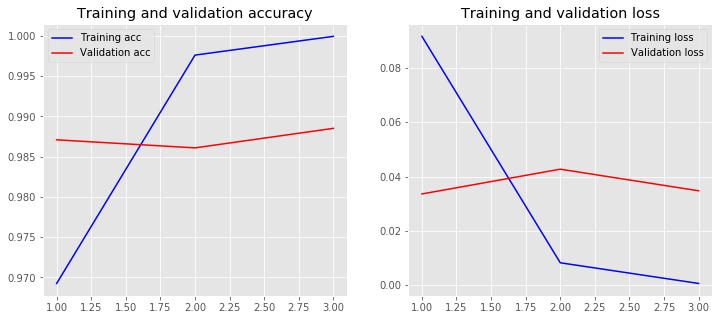

In [28]:
loss, accuracy = model_large.evaluate(X_2_train_large, integer_encoded_train_large, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_large.evaluate(X_2_test_large, integer_encoded_test_large, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_large)

33000/33000 [==============================] - ETA: 26:2 - ETA: 23:1 - ETA: 22:1 - ETA: 21:4 - ETA: 21:3 - ETA: 21:1 - ETA: 21:0 - ETA: 20:5 - ETA: 20:4 - ETA: 20:3 - ETA: 20:2 - ETA: 20:2 - ETA: 20:1 - ETA: 20:1 - ETA: 20:0 - ETA: 20:0 - ETA: 20:0 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:3 - ETA: 19:3 - ETA: 19:3 - ETA: 19:3 - ETA: 19:3 - ETA: 19:2 - ETA: 19:2 - ETA: 19:2 - ETA: 19:2 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 18:5 - ETA: 18:5 - ETA: 18:5 - ETA: 18:5 - ETA: 18:5 - ETA: 18:4 - ETA: 18:4 - ETA: 18:4 - ETA: 18:4 - ETA: 18:3 - ETA: 18:3 - ETA: 18:3 - ETA: 18:3 - ETA: 18:3 - ETA: 18:2 - ETA: 18:2 - ETA: 18:2 - ETA: 18:2 - ETA: 18:2 - ETA: 18:1 - ETA: 18:1 - ETA: 18:1 - ETA: 18:1 - ETA: 18:1 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:4 - ETA: 17:4 - ETA: 17:4 - ETA: 17:4 - ETA: 

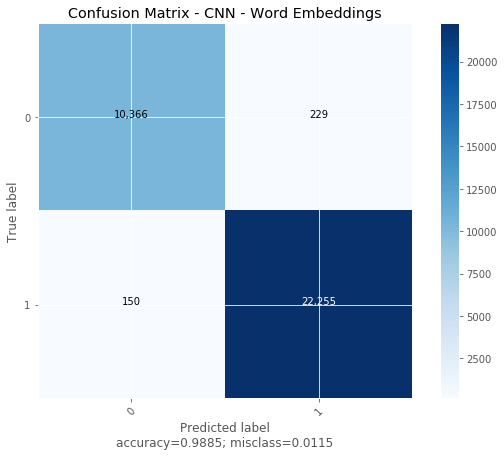

In [29]:
keras_pred_large = model_large.predict_classes(X_2_test_large, batch_size=50, verbose=1)
keras_cm_large = metrics.confusion_matrix(integer_encoded_test_large, keras_pred_large, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm_large, normalize=False, target_names=[0, 1],
                      title = 'Confusion Matrix - CNN - Word Embeddings')

### Using Recurrent Neural Network

In [35]:
embedding_dim2_large = 100

model2_large = Sequential()
model2_large.add(layers.Embedding(input_dim=vocab_size_large, output_dim=embedding_dim2_large, input_length=8000))
model2_large.add(layers.LSTM(128))
model2_large.add(layers.Dense(10, activation='relu'))
model2_large.add(layers.Dense(1, activation='sigmoid'))
model2_large.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2_large.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 8000, 100)         40384200  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 40,502,749
Trainable params: 40,502,749
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history_large = model2_large.fit(X_2_train_large, integer_encoded_train_large,
                    epochs=3,
                    verbose=1,
                    validation_data=(X_2_test_large, integer_encoded_test_large),
                    batch_size=50) #batch_size >= 150 pc stops working


Train on 67000 samples, validate on 33000 samples
Epoch 1/3
 1700/67000 [..............................] - ETA: 279:42:49 - loss: 0.6917 - acc: 0.68 - ETA: 318:55:50 - loss: 0.6896 - acc: 0.66 - ETA: 323:55:31 - loss: 0.6862 - acc: 0.67 - ETA: 296:11:48 - loss: 0.6855 - acc: 0.65 - ETA: 278:36:22 - loss: 0.6844 - acc: 0.64 - ETA: 265:11:20 - loss: 0.6773 - acc: 0.66 - ETA: 255:25:12 - loss: 0.6726 - acc: 0.66 - ETA: 247:53:58 - loss: 0.6707 - acc: 0.66 - ETA: 242:32:16 - loss: 0.6664 - acc: 0.66 - ETA: 238:51:08 - loss: 0.6655 - acc: 0.66 - ETA: 236:08:12 - loss: 0.6622 - acc: 0.66 - ETA: 233:30:03 - loss: 0.6656 - acc: 0.66 - ETA: 232:24:47 - loss: 0.6614 - acc: 0.66 - ETA: 229:20:38 - loss: 0.6548 - acc: 0.67 - ETA: 227:22:45 - loss: 0.6539 - acc: 0.66 - ETA: 225:29:29 - loss: 0.6495 - acc: 0.67 - ETA: 223:47:46 - loss: 0.6491 - acc: 0.67 - ETA: 222:58:45 - loss: 0.6437 - acc: 0.67 - ETA: 221:48:41 - loss: 0.6420 - acc: 0.68 - ETA: 221:13:20 - loss: 0.6379 - acc: 0.68 - ETA: 220:15:5

In [ ]:
keras_pred2_large = model2_large.predict_classes(X_2_test_large, batch_size=50, verbose=1)
keras_cm2_large = metrics.confusion_matrix(integer_encoded_test_large, keras_pred2_large, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm2_large, normalize=False, target_names=[0, 1],
                      title = 'Confusion Matrix - RNN - Word Embeddings')